In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.integrate as integrate
import scipy.optimize as optimize
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from sklearn.neighbors import KernelDensity
from scipy.ndimage import gaussian_filter1d
from scipy.stats import gaussian_kde
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal, qmc, norm
from sympy import symbols, itermonomials, lambdify, Mul, Matrix
from sympy.polys.monomials import itermonomials
from sympy.polys.orderings import monomial_key
from sympy.utilities.lambdify import implemented_function
from scipy import stats

In [ ]:
def lhs_normal (num_samples, mean, cov_matrix, seed):
    num_dimensions = cov_matrix.shape[0]
    lhs_sampler = qmc.LatinHypercube(d=num_dimensions, seed=seed)
    lhs_samples_uniform = lhs_sampler.random(n=num_samples)
    lhs_samples_standard_normal = norm.ppf(lhs_samples_uniform)
    L = np.linalg.cholesky(cov_matrix)
    lhs_samples = lhs_samples_standard_normal @ L.T + mean
    return lhs_samples

def cal_mean_std(mu,sigma):
    var = np.log(1 + (sigma/mu)**2)
    mean = np.log(mu) - var / 2
    std_dev = np.sqrt(var)
    return [mean, std_dev]

def compute_covariance_matrix_multi(standard_deviations, correlation_coefficient, num_variables):
    # 표준편차의 배열을 기반으로 대각행렬 초기화
    covariance_matrix = np.zeros((num_variables, num_variables))

    # 대각 성분에 표준편차 제곱값을 넣기
    np.fill_diagonal(covariance_matrix, np.array(standard_deviations) ** 2)

    # 상관관계에 따른 공분산 요소 계산
    for i in range(num_variables):
        for j in range(i + 1, num_variables):
            covariance_matrix[i, j] = correlation_coefficient * standard_deviations[i] * standard_deviations[j]
            covariance_matrix[j, i] = covariance_matrix[i, j]

    return covariance_matrix

def sampling(log_mean,log_cov,cor_coef,samping_number,seed):
    log_sig = np.sqrt(log_cov)
    gau_mean, gau_sigma = cal_mean_std(log_mean,log_sig)

    gau_cov = compute_covariance_matrix_multi(gau_sigma,cor_coef,len(gau_mean))

    samples = lhs_normal(samping_number, gau_mean, gau_cov, seed)
    return samples

def DD_GenP(x, m, S):
    ## generate P_m matrix (a vector of random monomials)
    ## mth order N random variables
    ## graded lexicographic
    ## input
        ## N : number of random variables
        ## m : max order of monomial
        ## x : random samples
    ## output
        ## Pm : vector of random monomials
    N = x.shape[1]
    variables = symbols(f'x:{N}') 
    P = sorted(itermonomials(variables, m), key=monomial_key('grlex', list(reversed(variables))))
    var_dict=dict(zip(variables, x.T))
    Pm = np.ones((1,np.shape(x)[0]))
    for monomial in P[1:]:
        mono_base = []
        if len(Mul.make_args(monomial)) <= S:
            for i in range(len(Mul.make_args(monomial))):
                base = Mul.make_args(monomial)[i].as_base_exp()[0]
                mono_base = np.append(mono_base,base)
            f = lambdify(mono_base, monomial,'numpy')
            val = np.zeros((1,np.shape(x)[0]))
            if monomial.is_Pow :
                val = var_dict[mono_base[0]]
                mono_val = np.array([f(val)])
            elif monomial.is_Mul:
                for i in range(len(Mul.make_args(monomial))):
                    val_tmp = np.array([var_dict[mono_base[i]]])
                    val = np.concatenate((val,val_tmp),axis=0)
                val = np.delete(val,0,axis=0)
                mono_val = np.array([f(*val)])
            else:
                mono_val = np.array([var_dict[monomial]])
            Pm = np.concatenate((Pm,mono_val),axis=0)
        else:
            pass
    return Pm

def compute_covariance_matrix(standard_deviation,correlation_coefficient,num_variables):
    covariance_matrix = np.zeros((num_variables, num_variables))
    np.fill_diagonal(covariance_matrix, standard_deviation**2)
    for i in range(num_variables):
        for j in range(i + 1, num_variables):
            covariance_matrix[i, j] = correlation_coefficient * standard_deviation ** 2
            covariance_matrix[j, i] = correlation_coefficient * standard_deviation ** 2
    return(covariance_matrix)

def compute_kde(data, x_grid, bandwidth):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data)
    log_dens = kde.score_samples(x_grid)
    return np.exp(log_dens)

def inverse_transform_sampling(pdf_vals, num_samples, x_vals, seed):
    """
    pdf_vals: 1D numpy array of PDF values (not necessarily normalized)
    num_samples: number of samples to generate
    x_vals: optional, x-coordinates corresponding to PDF values
    Returns: samples drawn from the distribution
    """
    np.random.seed(seed)  # Set random seed for reproducibility
    # Define x-axis if not provided
    n = len(pdf_vals)
    if x_vals is None:
        x_vals = np.linspace(0, 1, n)

    # Normalize the PDF to ensure area = 1
    dx = x_vals[1] - x_vals[0]
    pdf_vals = pdf_vals / (np.sum(pdf_vals) * dx)

    # Compute CDF
    cdf_vals = np.cumsum(pdf_vals) * dx
    cdf_vals = np.clip(cdf_vals, 0, 1)  # Ensure numerical safety

    # Create inverse CDF interpolator
    inv_cdf = interp1d(cdf_vals, x_vals, bounds_error=False, fill_value=(x_vals[0], x_vals[-1]))

    # Generate uniform samples and map through inverse CDF
    u = np.random.uniform(0, 1, num_samples)
    samples = inv_cdf(u)

    return samples

def sub_matrix(matrix, first_index, second_index):
    return matrix[np.ix_(first_index, second_index)]

def re_matrix(matrix, sub_matrix, first_index, second_index):
    matrix[np.ix_(first_index, second_index)] = sub_matrix
    return matrix

def clip_to_whisker(y):
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    y_clipped = np.clip(y, lower_bound, upper_bound)
    return y_clipped

def fast_2d_inverse_transform_sampling(pdf_values, x_grid, y_grid, n_samples=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    # dx, dy
    dx = x_grid[1] - x_grid[0]
    dy = y_grid[1] - y_grid[0]

    # 1️⃣ Marginal PDF over x (integrate along y-axis)
    marginal_pdf_x = np.sum(pdf_values, axis=1) * dy
    marginal_cdf_x = cumtrapz(marginal_pdf_x, x_grid, initial=0)
    marginal_cdf_x /= marginal_cdf_x[-1]
    inv_cdf_x = interp1d(marginal_cdf_x, x_grid, bounds_error=False,
                         fill_value=(x_grid[0], x_grid[-1]))

    # 2️⃣ Precompute conditional CDFs along y for each x index
    conditional_cdfs_y = []
    for i in range(len(x_grid)):
        cond_pdf = pdf_values[i, :]
        if cond_pdf.sum() > 0:
            cond_pdf = cond_pdf / (cond_pdf.sum() * dy)
            cond_cdf = cumtrapz(cond_pdf, y_grid, initial=0)
            cond_cdf /= cond_cdf[-1]
        else:
            cond_cdf = np.linspace(0, 1, len(y_grid))  # uniform fallback
        conditional_cdfs_y.append(
            interp1d(cond_cdf, y_grid, bounds_error=False,
                     fill_value=(y_grid[0], y_grid[-1]))
        )

    # 3️⃣ Sample from joint distribution
    u1 = np.random.uniform(0, 1, n_samples)
    x_samples = inv_cdf_x(u1)

    # Map x_samples to nearest x_grid index for conditional
    x_indices = np.abs(x_samples[:, None] - x_grid).argmin(axis=1)

    y_samples = np.zeros(n_samples)
    for i in range(n_samples):
        u2 = np.random.uniform()
        y_samples[i] = conditional_cdfs_y[x_indices[i]](u2)

    samples = np.column_stack([x_samples, y_samples])
    return samples

def kde_sampling(kde_set, n_samples):
    eps = 0.1
    if kde_set.shape[1] == 1:
        lim_min = np.min(kde_set) - np.std(kde_set)
        lim_max = np.max(kde_set) + np.std(kde_set)
        x = np.mgrid[lim_min:lim_max:1000j]
        grid_coords = np.vstack([x.ravel()])
        x_axes = np.linspace(lim_min, lim_max, 1000)
        shape = x.shape[0]
        n = len(kde_set[:, [0]])
        d = kde_set.shape[1]
        h = (4/(d+2))**(1/(d+4))*n**(-1/(d+4))
        kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
        kde_orign.fit(kde_set)
        kde_dens = kde_orign.score_samples(grid_coords.T)
        kde_dens = np.exp(kde_dens).reshape(shape)

        # Bootstrap bias correction
        n_bootstrap = 100
        boot_kdes = []
        n = len(kde_set[:, [0]])
        for _ in range(n_bootstrap):
            x_star = kde_set[np.random.choice(n, n, replace=True)]
            epsilon = np.random.normal(0, eps, size=n).reshape(-1, 1)
            x_plus = x_star + epsilon*h
            boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(shape))
        boot_kdes = np.array(boot_kdes)
        bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)
        samples = inverse_transform_sampling(bias_corrected, n_samples, x_axes, seed=42)
        samples_norm = samples / np.mean(samples)
        samples_norm = samples_norm.reshape(-1, 1)

    else:  # 2D
        lim_min = np.min(kde_set, axis=0) - np.std(kde_set, axis=0)
        lim_max = np.max(kde_set, axis=0) + np.std(kde_set, axis=0)
        n = len(kde_set[:, [0]])
        d = kde_set.shape[1]
        x, y = np.mgrid[lim_min[0]:lim_max[0]:100j, lim_min[1]:lim_max[1]:100j]
        grid_coords = np.vstack([x.ravel(), y.ravel()])
        x_axes = np.linspace(lim_min[0], lim_max[0], 100) 
        y_axes = np.linspace(lim_min[1], lim_max[1], 100)
        shape = (x.shape[0], x.shape[0])
        h = (4/(d+2))**(1/(d+4))*n**(-1/(d+4))
        kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
        kde_orign.fit(kde_set)
        kde_dens = kde_orign.score_samples(grid_coords.T)
        kde_dens = np.exp(kde_dens).reshape(shape)

        # Bootstrap bias correction
        n_bootstrap = 100
        boot_kdes = []
        n = len(kde_set[:, [0]])
        for _ in range(n_bootstrap):
            x_star = kde_set[np.random.choice(n, n, replace=True)]
            epsilon = np.random.normal(0, eps, size=n).reshape(-1, 1)
            x_plus = x_star + epsilon*h
            boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(shape))
        boot_kdes = np.array(boot_kdes)
        bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)
        samples = fast_2d_inverse_transform_sampling(bias_corrected, x_axes, y_axes, n_samples, seed=42)
        samples_norm = samples / np.mean(samples, axis=0)

    return samples_norm

def extract_variable_indices(expr, variables):
    used_vars = set()
    for term in Mul.make_args(expr):
        base = term.as_base_exp()[0]
        if base in variables:
            used_vars.add(base)
    return sorted([variables.index(v) for v in used_vars])

def silverman(x):
    n, d = x.shape
    return (4/(d+2))**(1/(d+4))*n**(-1/(d+4))

def Y (x_samples):
    y=2500-0.5*((2/15)*x_samples[:,0]-(1/180)*x_samples[:,1]**2)**2
    return y 

def DD_GPCE(x_samples, train_x, train_y, order, S):
    P = DD_GenP(x_samples, order, S)
    G = (P @ P.T)/len(x_samples)
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q)
    B = train_y
    P_t = DD_GenP(train_x,order, S)
    A = (W @ P_t).T
    C = np.linalg.inv(A.T @ A) @ A.T @ B
    gpce_mean = C[0]
    gpce_var = np.sum(C**2)-C[0]**2
    return gpce_mean, gpce_var


def joint_pdf(x1, x2):
    if x1 < 0 or x2 < 0:
        return 0
    else:
        return np.exp(-(x1 + x2 + x1 * x2)) * ((1 + x1) * (1 + x2) - 1)


def marginal_pdf_x1(x1):
    if x1 < 0:
        return 0
    integrand = lambda x2: joint_pdf(x1, x2)
    result, _ = integrate.quad(integrand, 0, np.inf)
    return result


def cdf_x1(x1):
    if x1 < 0:
        return 0
    # integrand = lambda t: marginal_pdf_x1(t)
    # result, _ = integrate.quad(integrand, 0, x1)
    result = 1 - np.exp(-x1)
    return result

def inverse_cdf_x1(u,initial_bracket = (0,100), max_iter = 10, step_size = 10):
    low, high = initial_bracket
    for _ in range(max_iter):
        result = optimize.root_scalar(lambda x: cdf_x1(x) - u, bracket=[low, high])
        if result.converged:
            return result.root
        high += step_size


def conditional_pdf_x2_given_x1(x2, x1):
    return joint_pdf(x1, x2) / marginal_pdf_x1(x1)


def cdf_x2_given_x1(x2, x1):
    if x2 < 0:
        return 0
    integrand = lambda t: conditional_pdf_x2_given_x1(t, x1)
    result, _ = integrate.quad(integrand, 0, x2)
    return result

def inverse_cdf_x2_given_x1(u, x1, initial_bracket = (0,100), max_iter = 10, step_size = 10):
    def func(x):
        return cdf_x2_given_x1(x,x1)-u
    
    low, high = initial_bracket
    for _ in range(max_iter):
        if func(low) * func(high) < 0:
            result = optimize.root_scalar(func, bracket=[low,high])
            if result.converged:
                return result.root
        high += step_size
    
    raise ValueError("Could not find a valid bracket where the function chages sign")

def Exponential_sampling(size, seed):
    """
    Exponential 분포 기반 샘플링 (Latin Hypercube Sampling 버전)
    """
    # 1. LHS 설계 생성기 초기화 (2차원: u1, u2)
    sampler = qmc.LatinHypercube(d=2, seed=seed)

    # 2. [0, 1] 구간에서 LHS 샘플 생성
    u = sampler.random(n=size)
    u1, u2 = u[:, 0], u[:, 1]

    # 3. inverse CDF 변환 수행
    samples = []
    for i in range(size):
        x1 = inverse_cdf_x1(u1[i])
        x2 = inverse_cdf_x2_given_x1(u2[i], x1)
        samples.append((x1, x2))

    return np.array(samples)

opt = 'cnstn' # constraint function
cntRspCon = 0 # counter of constraint function
def RSPSF_TRUSSf2(X):
    global cntRspCon, opt
    NX = len(X)
    Z = X
    crt = isinstance(X, list) #0: Vector, 1: Cell 
    w = 0 # initialize weight of truss 

    if crt == 0: # CASE: VECTOR     
        # information of truss 
        nElem = 10
        nDof = 2 # d.o.f of bar element 
        nNode = 6
        PV = -1E5 # Unit: lbf, vertical loading 
        L = 360 # Unit: in 
        rho = 0.1 # Unit: lb/in^3 
        E = 10**7 # Unit: lbf/in^2  
        C = E / L 

        # initialize truss FEM  
        elem = np.array([
            [1, 2], [2, 3], [3, 6], [5, 6], [4, 5],
            [1, 5], [2, 4], [2, 5], [2, 6], [3, 5]
        ]) - 1 # Convert to zero-based index for Python
        KK = np.zeros((nDof * nNode, nDof * nNode)) # stiffness matrix
        FF = np.zeros(nDof * nNode) # external force vector
        UU = np.zeros(nDof * nNode) # displacement vector 

        a1, a2 = mt.cos(mt.pi/4), mt.sin(mt.pi/4)
        b1, b2 = -mt.cos(mt.pi/4), mt.sin(mt.pi/4)
        # Transformation matrix 
        A = np.array([[a1, a2, 0, 0], [-a2, a1, 0, 0], [0, 0, a1, a2], [0, 0, -a2, a1]])
        B = np.array([[b1, b2, 0, 0], [-b2, b1, 0, 0], [0, 0, b1, b2], [0, 0, -b2, b1]])

        if opt == 'cnstn': # constraint function
            cntRspCon += 1
            # Construct global stiffness matrix 
            for ii in range(nElem):
                index = [elem[ii, 0] * nDof, elem[ii, 0] * nDof + 1, elem[ii, 1] * nDof, elem[ii, 1] * nDof + 1]
                
                if ii in [0, 1, 3, 4]:
                    KK[np.ix_(index, index)] += Z[ii] * C * np.array([[1, 0, -1, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, 0, 0, 0]])
                elif ii in [2, 7]:
                    KK[np.ix_(index, index)] += Z[ii] * C * np.array([[0, 0, 0, 0], [0, 1, 0, -1], [0, 0, 0, 0], [0, -1, 0, 1]])
                elif ii in [5, 8]:
                    KK[np.ix_(index, index)] += Z[ii] * (C / np.sqrt(2)) * A.T @ np.array([[1, 0, -1, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, 0, 0, 0]]) @ A
                elif ii in [6, 9]:
                    KK[np.ix_(index, index)] += Z[ii] * (C / np.sqrt(2)) * B.T @ np.array([[1, 0, -1, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, 0, 0, 0]]) @ B

            # Generation of Force matrix 
            FF[2 * nDof-1] = PV
            FF[3 * nDof-1] = PV

            # Boundary condition 
            delete_indices = [1*nDof-2, 1*nDof-1, 4*nDof-2, 4*nDof-1]
            KK = np.delete(KK, delete_indices, axis=0)
            KK = np.delete(KK, delete_indices, axis=1)
            FF = np.delete(FF, delete_indices)

            # Solve displacement 
            U = np.linalg.solve(KK, FF)

            # Ensure UU has correct size and shape
            sIndex = [2 * nDof - 2, 2 * nDof - 1, 3 * nDof - 2, 3 * nDof - 1, 5 * nDof - 2, 5 * nDof - 1, 6 * nDof - 2, 6 * nDof - 1]
            UU[sIndex] = U

            # Construct stress 
            con = np.sqrt(2) / 2
            S = np.zeros(nElem)
            for ii in range(nElem):
                index = [elem[ii, 0] * nDof, elem[ii, 0] * nDof + 1, elem[ii, 1] * nDof, elem[ii, 1] * nDof + 1]
                if ii in [0, 1, 3, 4]:
                    S[ii] = C * np.array([-1, 0, 1, 0]) @ UU[index]
                elif ii in [2, 7]:
                    S[ii] = C * np.array([0, -1, 0, 1]) @ UU[index]
                elif ii in [5, 8]:
                    S[ii] = (C / np.sqrt(2)) * np.array([-con, -con, con, con]) @ UU[index]
                elif ii in [6, 9]:
                    S[ii] = (C / np.sqrt(2)) * np.array([con, -con, -con, con]) @ UU[index]

            # define performance function 
            Y_U = 1.7 - abs(UU[3*nDof-1])
            Y_S = 10800- abs(S[0])
        else:
            raise ValueError('Wrong input')
    else:
        raise ValueError('Wrong input')
    
    YY = np.array([Y_U, Y_S])
    return YY

## Example 1: Mathematical function
### Case 1

In [168]:
GPCE_seed_list = [105, 30, 127, 530, 160, 851, 566, 180, 77, 716, 119, 293, 451, 406, 844, 115, 363, 45, 450, 3216]

In [170]:
Gaussian_kde_sample_list = []
for i in GPCE_seed_list:
    mean = [30, 30]
    seed = i
    std = 3.5
    rho = 0.5
    cov_matrix = np.array([[std**2,rho*std**2],[rho*std**2,std**2]])
    x_samples = lhs_normal(50, mean, cov_matrix, seed = seed)
    x_MCS = lhs_normal(10000, mean, cov_matrix, seed = seed)

    lim_min = np.min(x_samples, axis=0) - np.std(x_samples, axis=0)
    lim_max = np.max(x_samples, axis=0) + np.std(x_samples, axis=0)
    x, y = np.mgrid[lim_min[0]:lim_max[0]:100j, lim_min[1]:lim_max[1]:100j]
    grid_coords = np.vstack([x.ravel(), y.ravel()])
    x_axes = np.linspace(lim_min[0], lim_max[0], 100) 
    y_axes = np.linspace(lim_min[1], lim_max[1], 100)
    shape = (x.shape[0], x.shape[0])
    h = silverman(x_samples)
    kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_orign.fit(x_samples)
    kde_dens = kde_orign.score_samples(grid_coords.T)
    kde_dens = np.exp(kde_dens).reshape(x.shape[0], x.shape[1])

    # Bootstrap bias correction
    n_bootstrap = 100
    boot_kdes = []
    n = len(x_samples)
    h = silverman(x_samples)
    for _ in range(n_bootstrap):
        x_star = x_samples[np.random.choice(n, n, replace=True)]
        epsilon = np.random.normal(0, 0.1, size=n).reshape(-1, 1)
        x_plus = x_star + epsilon*h
        boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(x.shape[0], x.shape[1]))
    boot_kdes = np.array(boot_kdes)


    bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)
    kde_samples = fast_2d_inverse_transform_sampling(bias_corrected, x_axes,y_axes, n_samples=500000, seed = seed)
    Gaussian_kde_sample_list.append(kde_samples)

In [283]:
np.save('C:/Users/HojunChoi/Desktop/최호준/연구자료/논문/수학예제 결과/Input samples/Example 1/Case 1/Gaussian_kde_sample_list.npy', np.array(Gaussian_kde_sample_list))

In [ ]:
# DD-GPCE (m = 4, S = 2)

mean = [30, 30]
std = 3.5
rho = 0.5
cov_matrix = np.array([[std**2,rho*std**2],[rho*std**2,std**2]])

x_MCS = lhs_normal(1000000, mean, cov_matrix, seed = 42)
y_MCS = Y(x_MCS)
# Data-driven GPCE - DD_GPCE
m = 4
S = 2

dd_gpce_mean_list_1_s2 = []
dd_gpce_std_list_1_s2 = []
dd_gpce_mean_error_list_1_s2 = []
dd_gpce_std_error_list_1_s2 = []

c_gpce_mean_list_1_s2 = []
c_gpce_std_list_1_s2 = []
c_gpce_mean_error_list_1_s2 = []
c_gpce_std_error_list_1_s2 = []

t_gpce_mean_list_1_s2 = []
t_gpce_std_list_1_s2 = []
t_gpce_mean_error_list_1_s2 = []
t_gpce_std_error_list_1_s2 = []

for index, i in enumerate(GPCE_seed_list):
    seed = i
    x_samples = lhs_normal(50, mean, cov_matrix, seed = seed)
    
    y_train = Y(x_samples)
    x_train = x_samples
    kde_samples = Gaussian_kde_sample_list[index]

    P = DD_GenP(kde_samples/np.mean(kde_samples,axis = 0), m, S)
    G = (P @ P.T)/len(kde_samples)
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q)

    B = y_train
    P_t = DD_GenP(x_samples/np.mean(x_samples, axis = 0), m, S)
    A = (W @ P_t).T
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    gpce_mean = C[0]
    gpce_var = np.sum(C**2)-C[0]**2
    gpce_std = np.sqrt(gpce_var)
    dd_gpce_mean_list_1_s2.append(gpce_mean)
    dd_gpce_std_list_1_s2.append(gpce_std)
    mean_error = np.abs(gpce_mean - np.mean(y_MCS))/np.mean(y_MCS)*100
    dd_gpce_mean_error_list_1_s2.append(mean_error)
    std_error = np.abs(gpce_std - np.std(y_MCS))/np.std(y_MCS)*100
    dd_gpce_std_error_list_1_s2.append(std_error)

    # Classic GPCE with gaussian distribution
    mean_estimation = np.mean(x_samples, axis=0)
    cov_estimation = np.cov(x_samples.T)
    estimated_samples = lhs_normal(500000, mean_estimation, cov_estimation, seed)

    P_c = DD_GenP(estimated_samples/np.mean(estimated_samples, axis = 0), m, S)
    G_c = (P_c @ P_c.T)/len(estimated_samples)

    Q_c = np.linalg.cholesky(G_c)
    W_c = np.linalg.inv(Q_c)
    B_c = y_train
    P_t_c = DD_GenP(x_samples/np.mean(x_samples, axis = 0), m, S)
    A_c = (W_c @ P_t_c).T
    C_c = np.linalg.inv(A_c.T @ A_c) @ A_c.T @ B_c
    classic_gpce_mean_estimation = C_c[0]
    classic_gpce_var_estimation = np.sum(C_c**2)-C_c[0]**2
    classic_gpce_std_estimation = np.sqrt(classic_gpce_var_estimation)
    c_gpce_mean_list_1_s2.append(classic_gpce_mean_estimation)
    c_gpce_std_list_1_s2.append(classic_gpce_std_estimation)
    classic_gpce_mean_error = np.abs(classic_gpce_mean_estimation - np.mean(y_MCS))/np.mean(y_MCS)*100
    c_gpce_mean_error_list_1_s2.append(classic_gpce_mean_error)
    classic_gpce_std_error = np.abs(classic_gpce_std_estimation - np.std(y_MCS))/np.std(y_MCS)*100
    c_gpce_std_error_list_1_s2.append(classic_gpce_std_error)

    x_MCS_seed = lhs_normal(1000000, mean, cov_matrix, seed = seed)
    # Classic GPCE with true distribution
    true_gpce_mean_estimation, true_gpce_var_estimation = DD_GPCE(x_MCS_seed, x_train, y_train, m, S)
    t_gpce_mean_list_1_s2.append(true_gpce_mean_estimation)
    t_gpce_std_list_1_s2.append(np.sqrt(true_gpce_var_estimation))
    true_gpce_mean_error = np.abs(true_gpce_mean_estimation - np.mean(y_MCS))/np.mean(y_MCS)*100
    t_gpce_mean_error_list_1_s2.append(true_gpce_mean_error)
    true_gpce_std_error = np.abs(np.sqrt(true_gpce_var_estimation) - np.std(y_MCS))/np.std(y_MCS)*100
    t_gpce_std_error_list_1_s2.append(true_gpce_std_error)


In [286]:
mean = [30, 30]
std = 3.5
rho = 0.5
cov_matrix = np.array([[std**2,rho*std**2],[rho*std**2,std**2]])

for index, i in enumerate(GPCE_seed_list):
    seed = i
    x_MCS_seed = lhs_normal(1000000, mean, cov_matrix, seed = seed)

    np.save('C:/Users/HojunChoi/Desktop/최호준/연구자료/논문/수학예제 결과/Input samples/Example 1/Case 1/x_MCS/x_MCS_seed_'+str(seed)+'.npy', x_MCS_seed)

In [ ]:
# DD-GPCE (m = 4, S = 1)

mean = [30, 30]
std = 3.5
rho = 0.5
cov_matrix = np.array([[std**2,rho*std**2],[rho*std**2,std**2]])

x_MCS = lhs_normal(1000000, mean, cov_matrix, seed = 42)
y_MCS = Y(x_MCS)
# Data-driven GPCE - DD_GPCE
m = 4
S = 1

dd_gpce_mean_list_1_s1 = []
dd_gpce_std_list_1_s1 = []
dd_gpce_mean_error_list_1_s1 = []
dd_gpce_std_error_list_1_s1 = []

c_gpce_mean_list_1_s1 = []
c_gpce_std_list_1_s1 = []
c_gpce_mean_error_list_1_s1 = []
c_gpce_std_error_list_1_s1 = []
for index, i in enumerate(GPCE_seed_list):
    seed = i
    x_samples = lhs_normal(50, mean, cov_matrix, seed = seed)
    
    y_train = Y(x_samples)
    x_train = x_samples
    kde_samples = Gaussian_kde_sample_list[index]

    P = DD_GenP(kde_samples/np.mean(kde_samples,axis = 0), 4, 1)
    G = (P @ P.T)/len(kde_samples)
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q)

    B = y_train
    P_t = DD_GenP(x_samples/np.mean(x_samples, axis = 0), 4, 1)
    A = (W @ P_t).T
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    gpce_mean = C[0]
    gpce_var = np.sum(C**2)-C[0]**2
    gpce_std = np.sqrt(gpce_var)
    dd_gpce_mean_list_1_s1.append(gpce_mean)
    dd_gpce_std_list_1_s1.append(gpce_std)
    mean_error = np.abs(gpce_mean - np.mean(y_MCS))/np.mean(y_MCS)*100
    dd_gpce_mean_error_list_1_s1.append(mean_error)
    std_error = np.abs(gpce_std - np.std(y_MCS))/np.std(y_MCS)*100
    dd_gpce_std_error_list_1_s1.append(std_error)

    # Classic GPCE with gaussian distribution
    mean_estimation = np.mean(x_samples, axis=0)
    cov_estimation = np.cov(x_samples.T)
    estimated_samples = lhs_normal(500000, mean_estimation, cov_estimation, seed)

    P_c = DD_GenP(estimated_samples/np.mean(estimated_samples, axis = 0), 4, 1)
    G_c = (P_c @ P_c.T)/len(estimated_samples)
    Q_c = np.linalg.cholesky(G_c)
    W_c = np.linalg.inv(Q_c)
    B_c = y_train
    P_t_c = DD_GenP(x_samples/np.mean(x_samples, axis = 0), 4, 1)
    A_c = (W_c @ P_t_c).T
    C_c = np.linalg.inv(A_c.T @ A_c) @ A_c.T @ B_c
    classic_gpce_mean_estimation = C_c[0]
    classic_gpce_var_estimation = np.sum(C_c**2)-C_c[0]**2
    classic_gpce_std_estimation = np.sqrt(classic_gpce_var_estimation)
    c_gpce_mean_list_1_s1.append(classic_gpce_mean_estimation)
    c_gpce_std_list_1_s1.append(classic_gpce_std_estimation)
    classic_gpce_mean_error = np.abs(classic_gpce_mean_estimation - np.mean(y_MCS))/np.mean(y_MCS)*100
    c_gpce_mean_error_list_1_s1.append(classic_gpce_mean_error)
    classic_gpce_std_error = np.abs(classic_gpce_std_estimation - np.std(y_MCS))/np.std(y_MCS)*100
    c_gpce_std_error_list_1_s1.append(classic_gpce_std_error)


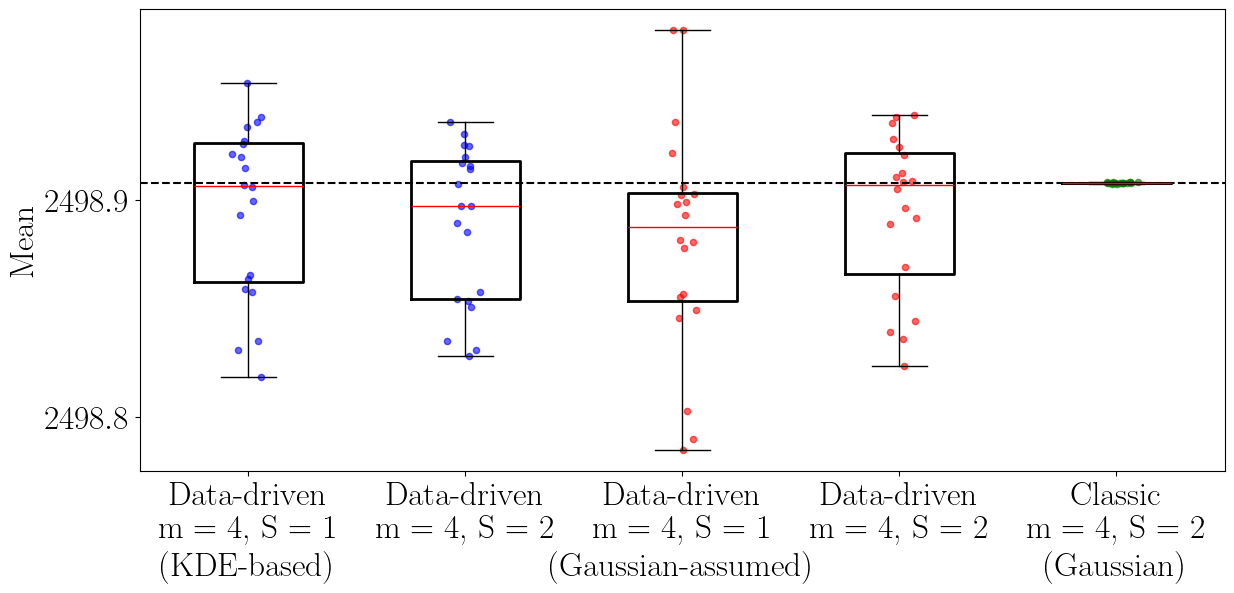

In [252]:
# Visualization - Boxplot of Mean
mean = [30, 30]
std = 3.5
rho = 0.5
cov_matrix = np.array([[std**2,rho*std**2],[rho*std**2,std**2]])

x_MCS = lhs_normal(1000000, mean, cov_matrix, seed = 42)
y_MCS = Y(x_MCS)
plt.style.use('default')
plt.rcParams['text.usetex'] = True  
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24


data = [dd_gpce_mean_list_1_s1, dd_gpce_mean_list_1_s2, c_gpce_mean_list_1_s1, c_gpce_mean_list_1_s2, t_gpce_mean_list_1_s2]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 4, S = 1' +'\n'+'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 4, S = 2',
    'Data-driven\nm = 4, S = 1 \n (Gaussian-assumed)',
    'Data-driven\nm = 4, S = 2',
    'Classic \nm = 4, S = 2 \n (Gaussian)'
]

# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)
    
ax.set_ylabel('Mean')
ax.axhline(np.mean(y_MCS),color='black', linestyle='--', label = 'MCS mean')

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

In [176]:
# error calculation
dd_clipped_gpce_mean_error_list_s1 = np.abs((clipped_data[0] - np.mean(y_MCS)))/np.mean(y_MCS)*100
dd_clipped_gpce_mean_error_list_s2 = np.abs((clipped_data[1] - np.mean(y_MCS)))/np.mean(y_MCS)*100
c_clipped_gpce_mean_error_list_s1 = np.abs((clipped_data[2] - np.mean(y_MCS)))/np.mean(y_MCS)*100
c_clipped_gpce_mean_error_list_s2 = np.abs((clipped_data[3] - np.mean(y_MCS)))/np.mean(y_MCS)*100

# print min, max, mean relative error standard deviation (2 decimal places)
print("Data-driven GPCE(s1) variance error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(dd_clipped_gpce_mean_error_list_s1),
    np.max(dd_clipped_gpce_mean_error_list_s1),
    np.mean(dd_clipped_gpce_mean_error_list_s1)
))

print("Data-driven GPCE(s2) variance error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(dd_clipped_gpce_mean_error_list_s2),
    np.max(dd_clipped_gpce_mean_error_list_s2),
    np.mean(dd_clipped_gpce_mean_error_list_s2)
))

print("Classic GPCE(s1) (Gaussian assumption) variance error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(c_clipped_gpce_mean_error_list_s1),
    np.max(c_clipped_gpce_mean_error_list_s1),
    np.mean(c_clipped_gpce_mean_error_list_s1)
))

print("Classic GPCE(s2) (Gaussian assumption) variance error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(c_clipped_gpce_mean_error_list_s2),
    np.max(c_clipped_gpce_mean_error_list_s2),
    np.mean(c_clipped_gpce_mean_error_list_s2)
))


Data-driven GPCE(s1) variance error (%): min = 0.00004, max = 0.00358, mean = 0.00130
Data-driven GPCE(s2) variance error (%): min = 0.00002, max = 0.00318, mean = 0.00126
Classic GPCE(s1) (Gaussian assumption) variance error (%): min = 0.00008, max = 0.00493, mean = 0.00177
Classic GPCE(s2) (Gaussian assumption) variance error (%): min = 0.00003, max = 0.00337, mean = 0.00116


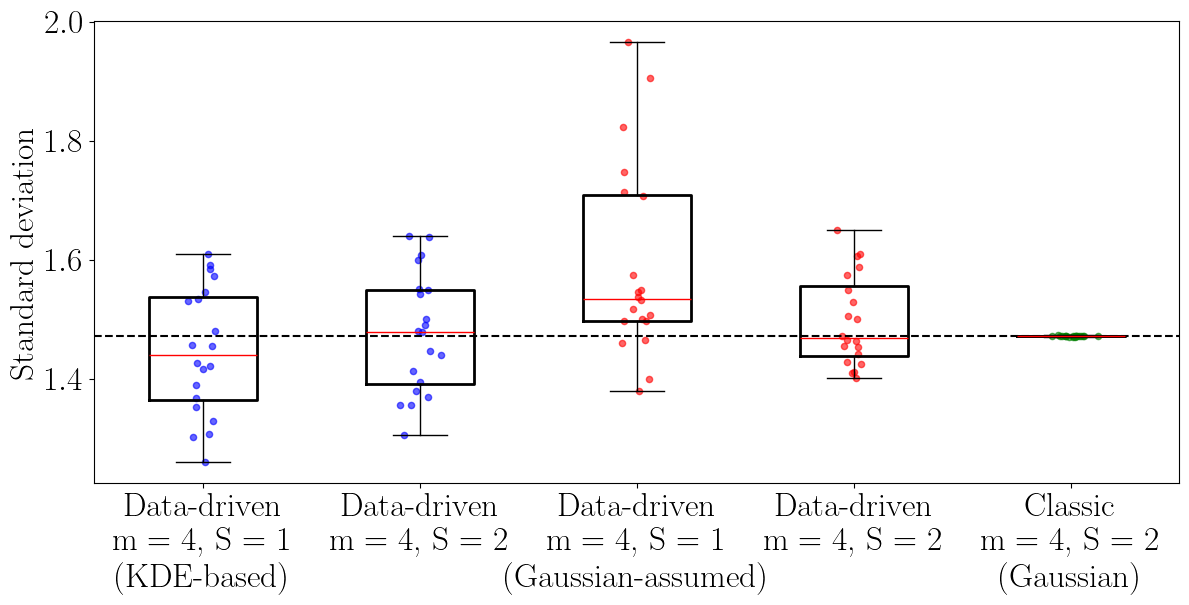

In [253]:
# Visualization - Boxplot of Standard Deviation
plt.style.use('default')
plt.rcParams['text.usetex'] = True  
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24


data = [dd_gpce_std_list_1_s1, dd_gpce_std_list_1_s2, c_gpce_std_list_1_s1, c_gpce_std_list_1_s2, t_gpce_std_list_1_s2]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 4, S = 1' +'\n'+'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 4, S = 2',
    'Data-driven\nm = 4, S = 1 \n (Gaussian-assumed)',
    'Data-driven\nm = 4, S = 2',
    'Classic \nm = 4, S = 2 \n (Gaussian)'
]

# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red','green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)

    
ax.set_ylabel('Standard deviation')
ax.axhline(np.std(y_MCS),color='black', linestyle='--', label = 'MCS std')

# ax.legend(loc = 'upper left')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

In [254]:
# error calculation
dd_clipped_gpce_std_error_list_s1 = np.abs((clipped_data[0] - np.std(y_MCS)))/np.std(y_MCS)*100
dd_clipped_gpce_std_error_list_s2 = np.abs((clipped_data[1] - np.std(y_MCS)))/np.std(y_MCS)*100
c_clipped_gpce_std_error_list_s1 = np.abs((clipped_data[2] - np.std(y_MCS)))/np.std(y_MCS)*100
c_clipped_gpce_std_error_list_s2 = np.abs((clipped_data[3] - np.std(y_MCS)))/np.std(y_MCS)*100
t_clipped_gpce_std_error_list_s2 = np.abs((clipped_data[4] - np.std(y_MCS)))/np.std(y_MCS)*100

# print min, max, mean relative error standard deviation (2 decimal places)
print("Data-driven GPCE(s1) variance error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(dd_clipped_gpce_std_error_list_s1),
    np.max(dd_clipped_gpce_std_error_list_s1),
    np.mean(dd_clipped_gpce_std_error_list_s1)
))

print("Data-driven GPCE(s2) variance error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(dd_clipped_gpce_std_error_list_s2),
    np.max(dd_clipped_gpce_std_error_list_s2),
    np.mean(dd_clipped_gpce_std_error_list_s2)
))

print("Data-driven GPCE(s1) (Gaussian assumption) variance error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(c_clipped_gpce_std_error_list_s1),
    np.max(c_clipped_gpce_std_error_list_s1),
    np.mean(c_clipped_gpce_std_error_list_s1)
))

print("Data-driven GPCE(s2) (Gaussian assumption) variance error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(c_clipped_gpce_std_error_list_s2),
    np.max(c_clipped_gpce_std_error_list_s2),
    np.mean(c_clipped_gpce_std_error_list_s2)
))

print("Classic GPCE(s2) variance error (%): min = {:.10f}, max = {:.10f}, mean = {:.10f}".format(
    np.min(t_clipped_gpce_std_error_list_s2),
    np.max(t_clipped_gpce_std_error_list_s2),
    np.mean(t_clipped_gpce_std_error_list_s2)
))


Data-driven GPCE(s1) variance error (%): min = 0.63, max = 14.41, mean = 6.29
Data-driven GPCE(s2) variance error (%): min = 0.46, max = 11.40, mean = 5.68
Data-driven GPCE(s1) (Gaussian assumption) variance error (%): min = 0.38, max = 33.51, mean = 9.35
Data-driven GPCE(s2) (Gaussian assumption) variance error (%): min = 0.04, max = 12.15, mean = 4.19
Classic GPCE(s2) variance error (%): min = 0.0001758303, max = 0.1027358789, mean = 0.0387644386


### Case 2

In [185]:
GPCE_seed_list = [105, 30, 127, 530, 160, 851, 566, 180, 77, 716, 119, 293, 451, 406, 844, 115, 363, 45, 450, 3216]

In [ ]:
# sampling
Logrnormal_kde_sample_list = []
log_mean = [3.398]*2
log_std = 0.1
seed = 42

mean = log_mean
std_dev = log_std
cov_matrix = compute_covariance_matrix(std_dev,0.5,2)
seed = i
x_samples = np.exp(lhs_normal(50, mean, cov_matrix, seed = seed))
x_MCS = np.exp(lhs_normal(10000, mean, cov_matrix, seed = seed))

In [187]:
Logrnormal_kde_sample_list = []
log_mean = [3.398]*2
log_std = 0.1
eps_num = 0.5
for i in GPCE_seed_list:
    mean = log_mean
    std_dev = log_std
    cov_matrix = compute_covariance_matrix(std_dev,0.5,2)
    seed = i
    x_samples = np.exp(lhs_normal(50, mean, cov_matrix, seed = seed))
    x_MCS = np.exp(lhs_normal(10000, mean, cov_matrix, seed = seed))

    lim_min = np.min(x_samples, axis=0) - np.std(x_samples, axis=0)
    lim_max = np.max(x_samples, axis=0) + np.std(x_samples, axis=0)
    x, y = np.mgrid[lim_min[0]:lim_max[0]:100j, lim_min[1]:lim_max[1]:100j]
    grid_coords = np.vstack([x.ravel(), y.ravel()])
    x_axes = np.linspace(lim_min[0], lim_max[0], 100) 
    y_axes = np.linspace(lim_min[1], lim_max[1], 100)

    h = silverman(x_samples)
    kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_orign.fit(x_samples)
    kde_dens = kde_orign.score_samples(grid_coords.T)
    kde_dens = np.exp(kde_dens).reshape(x.shape[0], x.shape[1])

    # Bootstrap bias correction
    n_bootstrap = 100
    boot_kdes = []
    n = len(x_samples)
    h = silverman(x_samples)
    for _ in range(n_bootstrap):
        x_star = x_samples[np.random.choice(n, n, replace=True)]
        epsilon = np.random.normal(0, eps_num, size=n).reshape(-1, 1)
        x_plus = x_star + epsilon*h
        boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(x.shape[0], x.shape[1]))
    boot_kdes = np.array(boot_kdes)


    bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)

    kde_sample = fast_2d_inverse_transform_sampling(bias_corrected,x_axes,y_axes,n_samples=500000, seed=seed)
    Logrnormal_kde_sample_list.append(kde_sample)

In [288]:
log_mean = [3.398]*2
log_std = 0.1
eps_num = 0.5
for i in GPCE_seed_list:
    mean = log_mean
    std_dev = log_std
    cov_matrix = compute_covariance_matrix(std_dev,0.5,2)
    seed = i
    x_samples = np.exp(lhs_normal(50, mean, cov_matrix, seed = seed))
    x_MCS = np.exp(lhs_normal(10000, mean, cov_matrix, seed = seed))
    np.save('C:/Users/HojunChoi/Desktop/최호준/연구자료/논문/수학예제 결과/Input samples/Example 1/Case 2/x_samples/x_samples_seed_'+str(seed)+'.npy', x_samples)
    np.save('C:/Users/HojunChoi/Desktop/최호준/연구자료/논문/수학예제 결과/Input samples/Example 1/Case 2/x_MCS/x_MCS_seed_'+str(seed)+'.npy', x_MCS)

In [255]:
# DD-GPCE (m = 4, S = 2)

log_dd_gpce_mean_list_s2 = []
log_dd_gpce_std_list_s2 = []
log_dd_gpce_mean_error_list_s2 = []
log_dd_gpce_std_error_list_s2 = []

log_c_gpce_mean_list_s2 = []
log_c_gpce_std_list_s2 = []
log_c_gpce_mean_error_list_s2 = []
log_c_gpce_std_error_list_s2 = []

log_t_gpce_mean_list_s2 = []
log_t_gpce_std_list_s2 = []
log_t_gpce_mean_error_list_s2 = []
log_t_gpce_std_error_list_s2 = []

m = 4
S = 2

mean=log_mean
std_dev = log_std
cov_matrix = compute_covariance_matrix(std_dev,0.5,2)
x_MCS = np.exp(lhs_normal(1000000, mean, cov_matrix, seed = 42))
Y_MCS = Y(x_MCS)
Y_MCS_mean = np.mean(Y_MCS)
Y_MCS_std = np.std(Y_MCS)

for index, i in enumerate(GPCE_seed_list):

    seed = i
    x_samples = np.exp(lhs_normal(50, mean, cov_matrix, seed = seed))
    

    kde_samples = Logrnormal_kde_sample_list[index]

    # Data-driven DD_GPCE
    y_train = Y(x_samples)
    x_train = x_samples/np.mean(x_samples, axis=0)

    gpce_mean, gpce_var = DD_GPCE(kde_samples/np.mean(kde_samples,axis=0), x_train, y_train, m, S)
    gpce_std = np.sqrt(gpce_var)
    log_dd_gpce_mean_list_s2.append(gpce_mean)
    log_dd_gpce_std_list_s2.append(gpce_std)
    mean_error = np.abs(gpce_mean - np.mean(Y_MCS))/np.mean(Y_MCS)*100
    log_dd_gpce_mean_error_list_s2.append(mean_error)
    std_error = np.abs(gpce_std - np.std(Y_MCS))/np.std(Y_MCS)*100
    log_dd_gpce_std_error_list_s2.append(std_error)

    # classic DD_GPCE with gaussian distribution
    mean_estimation = np.mean(x_samples, axis=0)
    cov_estimation = np.cov(x_samples.T)
    estimated_samples = lhs_normal(500000, mean_estimation, cov_estimation, seed)


    classic_gpce_mean_estimation, classic_gpce_var_estimation = DD_GPCE(estimated_samples/np.mean(estimated_samples, axis=0), x_train, y_train, m, S)  
    classic_gpce_std_estimation = np.sqrt(classic_gpce_var_estimation)
    log_c_gpce_mean_list_s2.append(classic_gpce_mean_estimation)
    log_c_gpce_std_list_s2.append(classic_gpce_std_estimation)
    mean_error = np.abs(classic_gpce_mean_estimation - np.mean(Y_MCS))/np.mean(Y_MCS)*100
    log_c_gpce_mean_error_list_s2.append(mean_error)
    std_error = np.abs(classic_gpce_std_estimation - np.std(Y_MCS))/np.std(Y_MCS)*100
    log_c_gpce_std_error_list_s2.append(std_error)

    x_MCS_seed = np.exp(lhs_normal(1000000, mean, cov_matrix, seed = seed))
    # classic DD_GPCE with true distribution
    true_gpce_mean_estimation, true_gpce_var_estimation = DD_GPCE(x_MCS_seed/np.mean(x_MCS_seed, axis=0), x_train, y_train, m, S)
    true_gpce_std_estimation = np.sqrt(true_gpce_var_estimation)
    log_t_gpce_mean_list_s2.append(true_gpce_mean_estimation)
    log_t_gpce_std_list_s2.append(true_gpce_std_estimation)
    mean_error = np.abs(true_gpce_mean_estimation - np.mean(Y_MCS))/np.mean(Y_MCS)*100
    log_t_gpce_mean_error_list_s2.append(mean_error)
    std_error = np.abs(true_gpce_std_estimation - np.std(Y_MCS))/np.std(Y_MCS)*100
    log_t_gpce_std_error_list_s2.append(std_error)
    

In [189]:
# DD-GPCE (m = 4, S = 2)

log_dd_gpce_mean_list_s1 = []
log_dd_gpce_std_list_s1 = []
log_dd_gpce_mean_error_list_s1 = []
log_dd_gpce_std_error_list_s1 = []

log_c_gpce_mean_list_s1 = []
log_c_gpce_std_list_s1 = []
log_c_gpce_mean_error_list_s1 = []
log_c_gpce_std_error_list_s1 = []


m = 4
S = 1

mean= log_mean
std_dev = log_std
cov_matrix = compute_covariance_matrix(std_dev,0.5,2)
x_MCS = np.exp(lhs_normal(1000000, mean, cov_matrix, seed = 42))
Y_MCS = Y(x_MCS)
Y_MCS_mean = np.mean(Y_MCS)
Y_MCS_std = np.std(Y_MCS)

for index, i in enumerate(GPCE_seed_list):

    seed = i
    x_samples = np.exp(lhs_normal(50, mean, cov_matrix, seed = seed))
    

    kde_samples = Logrnormal_kde_sample_list[index]

    # Data-driven DD_GPCE
    y_train = Y(x_samples)
    x_train = x_samples/np.mean(x_samples, axis=0)

    gpce_mean, gpce_var = DD_GPCE(kde_samples/np.mean(kde_samples,axis=0), x_train, y_train, m, S)
    gpce_std = np.sqrt(gpce_var)
    log_dd_gpce_mean_list_s1.append(gpce_mean)
    log_dd_gpce_std_list_s1.append(gpce_std)
    mean_error = np.abs(gpce_mean - np.mean(Y_MCS))/np.mean(Y_MCS)*100
    log_dd_gpce_mean_error_list_s1.append(mean_error)
    std_error = np.abs(gpce_std - np.std(Y_MCS))/np.std(Y_MCS)*100
    log_dd_gpce_std_error_list_s1.append(std_error)

    # classic DD_GPCE with gaussian distribution
    mean_estimation = np.mean(x_samples, axis=0)
    cov_estimation = np.cov(x_samples.T)
    estimated_samples = lhs_normal(500000, mean_estimation, cov_estimation, seed)


    classic_gpce_mean_estimation, classic_gpce_var_estimation = DD_GPCE(estimated_samples/np.mean(estimated_samples, axis=0), x_train, y_train, m, S)  
    classic_gpce_std_estimation = np.sqrt(classic_gpce_var_estimation)
    log_c_gpce_mean_list_s1.append(classic_gpce_mean_estimation)
    log_c_gpce_std_list_s1.append(classic_gpce_std_estimation)
    mean_error = np.abs(classic_gpce_mean_estimation - np.mean(Y_MCS))/np.mean(Y_MCS)*100
    log_c_gpce_mean_error_list_s1.append(mean_error)
    std_error = np.abs(classic_gpce_std_estimation - np.std(Y_MCS))/np.std(Y_MCS)*100
    log_c_gpce_std_error_list_s1.append(std_error)

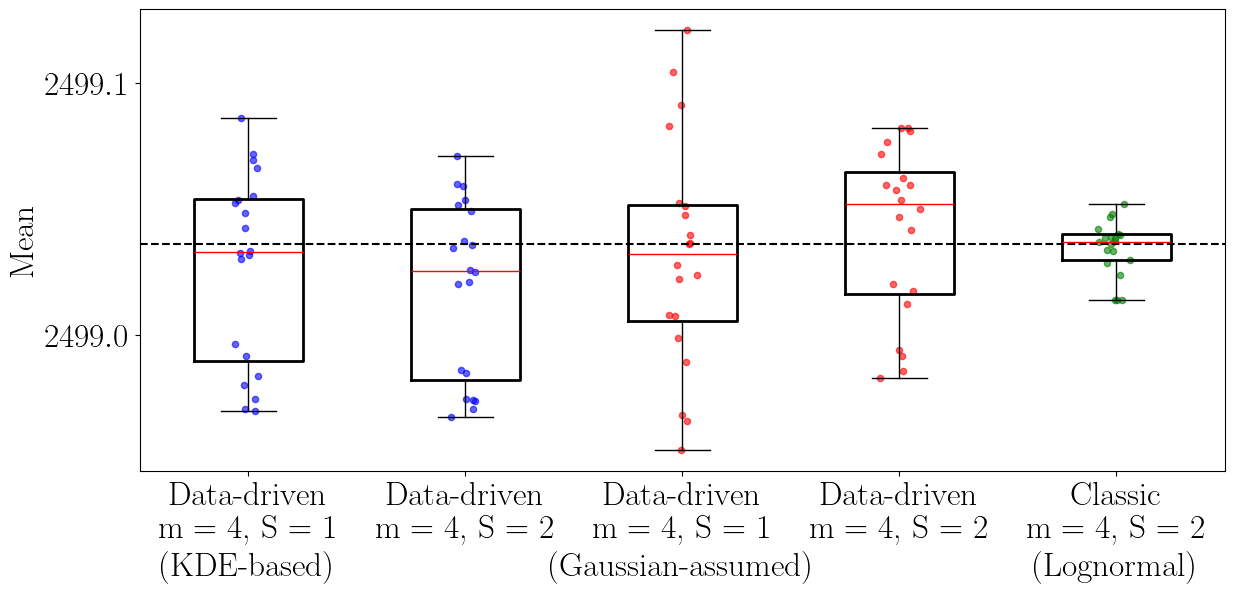

In [256]:
# Visualization - Boxplot of Mean (Lognormal case)
mean=log_mean
std_dev = log_std
cov_matrix = compute_covariance_matrix(std_dev,0.5,2)
x_MCS = np.exp(lhs_normal(1000000, mean, cov_matrix, seed = 42))
Y_MCS = Y(x_MCS)
Y_MCS_mean = np.mean(Y_MCS)

plt.style.use('default')
plt.rcParams['text.usetex'] = True 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24


data = [log_dd_gpce_mean_list_s1, log_dd_gpce_mean_list_s2, log_c_gpce_mean_list_s1, log_c_gpce_mean_list_s2, log_t_gpce_mean_list_s2]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 4, S = 1' +'\n'+'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 4, S = 2',
    'Data-driven\nm = 4, S = 1 \n (Gaussian-assumed)',
    'Data-driven\nm = 4, S = 2',
    'Classic \nm = 4, S = 2 \n (Lognormal)'
]

# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)
ax.set_ylabel('Mean')
ax.axhline(Y_MCS_mean,color='black', linestyle='--', label = 'MCS mean')

# plt.title('Box plot of mean values of DD-GPCE')
# ax.legend(loc = 'upper left')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

In [257]:
# error calculation
exp_dd_clipped_gpce_mean_error_list_s1 = np.abs((clipped_data[0] - np.mean(Y_MCS)))/np.mean(Y_MCS)*100
exp_dd_clipped_gpce_mean_error_list_s2 = np.abs((clipped_data[1] - np.mean(Y_MCS)))/np.mean(Y_MCS)*100
exp_c_clipped_gpce_mean_error_list_s1 = np.abs((clipped_data[2] - np.mean(Y_MCS)))/np.mean(Y_MCS)*100
exp_c_clipped_gpce_mean_error_list_s2 = np.abs((clipped_data[3] - np.mean(Y_MCS)))/np.mean(Y_MCS)*100

# print min, max, mean relative error standard deviation (2 decimal places)
print("Data-driven GPCE(s1) variance error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(exp_dd_clipped_gpce_mean_error_list_s1),
    np.max(exp_dd_clipped_gpce_mean_error_list_s1),
    np.mean(exp_dd_clipped_gpce_mean_error_list_s1)
))

print("Data-driven GPCE(s2) variance error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(exp_dd_clipped_gpce_mean_error_list_s2),
    np.max(exp_dd_clipped_gpce_mean_error_list_s2),
    np.mean(exp_dd_clipped_gpce_mean_error_list_s2)
))

print("Classic GPCE(s1) (Gaussian assumption) variance error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(exp_c_clipped_gpce_mean_error_list_s1),
    np.max(exp_c_clipped_gpce_mean_error_list_s1),
    np.mean(exp_c_clipped_gpce_mean_error_list_s1)
))

print("Classic GPCE(s2) (Gaussian assumption) variance error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(exp_c_clipped_gpce_mean_error_list_s2),
    np.max(exp_c_clipped_gpce_mean_error_list_s2),
    np.mean(exp_c_clipped_gpce_mean_error_list_s2)
))


Data-driven GPCE(s1) variance error (%): min = 0.00010, max = 0.00265, mean = 0.00124
Data-driven GPCE(s2) variance error (%): min = 0.00002, max = 0.00274, mean = 0.00121
Classic GPCE(s1) (Gaussian assumption) variance error (%): min = 0.00001, max = 0.00339, mean = 0.00139
Classic GPCE(s2) (Gaussian assumption) variance error (%): min = 0.00022, max = 0.00213, mean = 0.00121


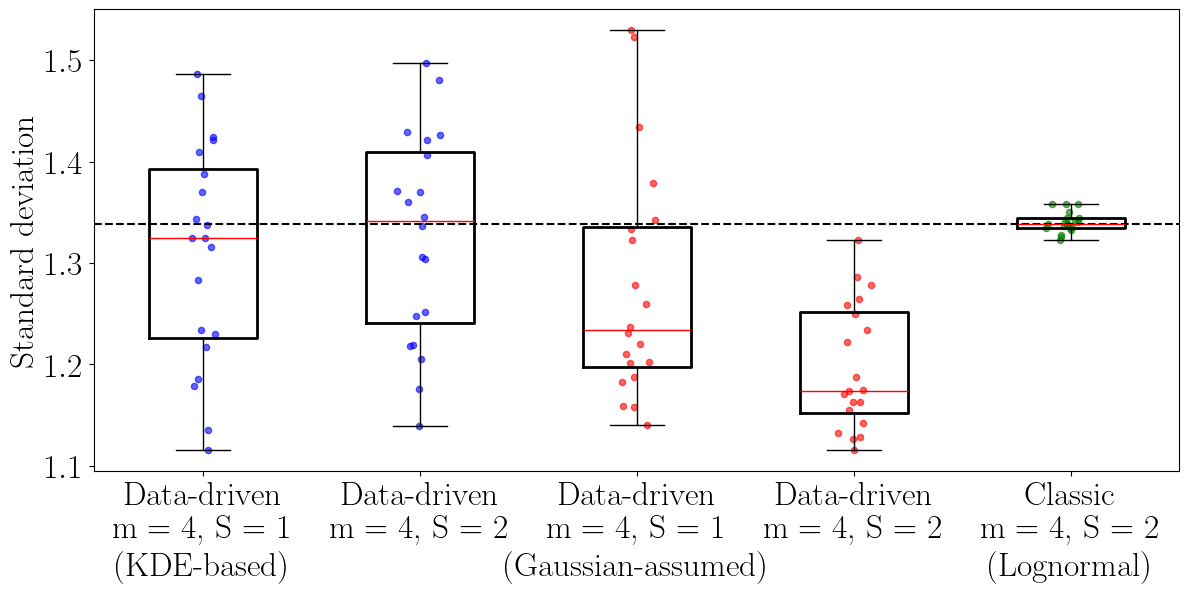

In [258]:
# Visualization - Boxplot of Standard Deviation (Lognormal case)
plt.style.use('default')
plt.style.use('default')
plt.rcParams['text.usetex'] = True 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24


data = [log_dd_gpce_std_list_s1, log_dd_gpce_std_list_s2, log_c_gpce_std_list_s1, log_c_gpce_std_list_s2, log_t_gpce_std_list_s2]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 4, S = 1' +'\n'+'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 4, S = 2',
    'Data-driven\nm = 4, S = 1 \n (Gaussian-assumed)',
    'Data-driven\nm = 4, S = 2',
    'Classic \nm = 4, S = 2 \n (Lognormal)'
]


# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red','green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)
ax.set_ylabel('Standard deviation')
ax.axhline(np.std(Y_MCS),color='black', linestyle='--', label = 'MCS std')

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

In [259]:
# error calculation
log_dd_clipped_gpce_std_error_list_s1 = np.abs((clipped_data[0] - np.std(Y_MCS)))/np.std(Y_MCS)*100
log_dd_clipped_gpce_std_error_list_s2 = np.abs((clipped_data[1] - np.std(Y_MCS)))/np.std(Y_MCS)*100
log_c_clipped_gpce_std_error_list_s1 = np.abs((clipped_data[2] - np.std(Y_MCS)))/np.std(Y_MCS)*100
log_c_clipped_gpce_std_error_list_s2 = np.abs((clipped_data[3] - np.std(Y_MCS)))/np.std(Y_MCS)*100
log_t_clipped_gpce_std_error_list_s2 = np.abs((clipped_data[4] - np.std(Y_MCS)))/np.std(Y_MCS)*100

# print min, max, mean relative error standard deviation (2 decimal places)
print("Data-driven GPCE(s1) variance error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(log_dd_clipped_gpce_std_error_list_s1),
    np.max(log_dd_clipped_gpce_std_error_list_s1),
    np.mean(log_dd_clipped_gpce_std_error_list_s1)
))

print("Data-driven GPCE(s2) variance error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(log_dd_clipped_gpce_std_error_list_s2),
    np.max(log_dd_clipped_gpce_std_error_list_s2),
    np.mean(log_dd_clipped_gpce_std_error_list_s2)
))

print("Data-driven GPCE(s1) (Gaussian assumption) variance error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(log_c_clipped_gpce_std_error_list_s1),
    np.max(log_c_clipped_gpce_std_error_list_s1),
    np.mean(log_c_clipped_gpce_std_error_list_s1)
))

print("Data-driven GPCE(s2) (Gaussian assumption) variance error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(log_c_clipped_gpce_std_error_list_s2),
    np.max(log_c_clipped_gpce_std_error_list_s2),
    np.mean(log_c_clipped_gpce_std_error_list_s2)
))

print("Classic GPCE(s2) (Lognormal) variance error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(log_t_clipped_gpce_std_error_list_s2),
    np.max(log_t_clipped_gpce_std_error_list_s2),
    np.mean(log_t_clipped_gpce_std_error_list_s2)
))


Data-driven GPCE(s1) variance error (%): min = 0.05, max = 16.62, mean = 6.64
Data-driven GPCE(s2) variance error (%): min = 0.09, max = 14.82, mean = 6.36
Data-driven GPCE(s1) (Gaussian assumption) variance error (%): min = 0.31, max = 14.76, mean = 8.45
Data-driven GPCE(s2) (Gaussian assumption) variance error (%): min = 1.16, max = 16.65, mean = 10.50
Classic GPCE(s2) (Lognormal) variance error (%): min = 0.00, max = 1.52, mean = 0.55


### Case 3

In [ ]:
# import data

x_true_list = np.load("exp_x_true_data.npy")


reshaped_x_train_list = np.zeros((30, 15, 2))


for i in range(30):
    start_idx = i * 30  
    end_idx = start_idx + 30  
    x1 = x_train_list[start_idx:start_idx + 15]  
    x2 = x_train_list[start_idx + 15:end_idx]  
    reshaped_x_train_list[i, :, 0] = x1  
    reshaped_x_train_list[i, :, 1] = x2  

reshaped_x_true_list = np.zeros((30, 20000, 2))

for i in range(30):
    start_idx = i * 40000 
    end_idx = start_idx + 40000  
    x1 = x_true_list[start_idx:start_idx + 20000]  
    x2 = x_true_list[start_idx + 20000:end_idx]  
    reshaped_x_true_list[i, :, 0] = x1  
    reshaped_x_true_list[i, :, 1] = x2 


In [200]:
GPCE_seed_list = [45,450,4555,5545,554564,554568,554569,79656,79652,7945,321,356,4132,3214,3215,3216,3217,3218,3219,6653]

In [201]:
Exp_kde_sample_list = []
eps_num = 0.5
for i in GPCE_seed_list:
    seed = i
    x_samples = Exponential_sampling(50, seed)

    # kde 계산

    lim_min = np.min(x_samples, axis=0) - np.std(x_samples, axis=0)
    lim_max = np.max(x_samples, axis=0) + np.std(x_samples, axis=0)
    # lim_max = [3.5, 6]
    x, y = np.mgrid[lim_min[0]:lim_max[0]:100j, lim_min[1]:lim_max[1]:100j]
    grid_coords = np.vstack([x.ravel(), y.ravel()])
    x_axes = np.linspace(lim_min[0], lim_max[0], 100) 
    y_axes = np.linspace(lim_min[1], lim_max[1], 100)
    h = silverman(x_samples)
    kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_orign.fit(x_samples)
    kde_dens = kde_orign.score_samples(grid_coords.T)
    kde_dens = np.exp(kde_dens).reshape(x.shape[0], x.shape[1])

    # Bootstrap bias correction
    n_bootstrap = 100
    boot_kdes = []
    n = len(x_samples)
    for _ in range(n_bootstrap):
        x_star = x_samples[np.random.choice(n, n, replace=True)]
        epsilon = np.random.normal(0, eps_num, size=n).reshape(-1, 1)
        x_plus = x_star + epsilon*h
        boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(x.shape[0], x.shape[1]))
    boot_kdes = np.array(boot_kdes)



    bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)

    kde_sample = fast_2d_inverse_transform_sampling(bias_corrected,x_axes,y_axes ,n_samples=500000, seed=seed)
    Exp_kde_sample_list.append(kde_sample)

In [202]:
X_MCS = np.vstack([reshaped_x_true_list[i] for i in range(30)])
Y_MCS = Y(X_MCS)

In [308]:
# DD-GPCE (m = 4, S = 2)

N = 2
m = 4
S = 2

# proposed method
exp_dd_gpce_mean_list = []
exp_dd_gpce_std_list = []
exp_dd_gpce_mean_error_list = []
exp_dd_gpce_std_error_list = []

# classic GPCE with gaussian distribution
exp_c_gpce_mean_list = []
exp_c_gpce_std_list = []
exp_c_gpce_mean_error_list = []
exp_c_gpce_std_error_list = []

# classic GPCE with true distribution
exp_t_gpce_mean_list = []
exp_t_gpce_std_list = []
exp_t_gpce_mean_error_list = []
exp_t_gpce_std_error_list = []

for index, i in enumerate(GPCE_seed_list):

    seed = i

    x_samples = Exponential_sampling(50, seed)
    # x_train = reshaped_x_train_list[index]
    x_train = x_samples
    
    kde_sample = Exp_kde_sample_list[index]

    # Data-driven GPCE
    # y_train = Y(x_train)
    y_train = Y(x_train)
    y_MCS = Y_MCS

    gpce_mean, gpce_var = DD_GPCE(kde_sample, x_train, y_train, m, S)
    exp_dd_gpce_mean_list.append(gpce_mean)
    gpce_std = np.sqrt(gpce_var)
    exp_dd_gpce_std_list.append(gpce_std)
    mean_error = np.abs(gpce_mean - np.mean(y_MCS))/np.mean(y_MCS)*100
    exp_dd_gpce_mean_error_list.append(mean_error)
    std_error = np.abs(gpce_std - np.std(y_MCS))/np.std(y_MCS)*100
    exp_dd_gpce_std_error_list.append(std_error)

    # classic GPCE with gaussian distribution
    mean_estimation = np.mean(x_samples, axis=0)
    cov_estimation = np.cov(x_samples.T)
    estimated_samples = lhs_normal(500000, mean_estimation, cov_estimation, seed)

    classic_gpce_mean_estimation, classic_gpce_var_estimation = DD_GPCE(estimated_samples, x_train, y_train, m, S)  
    classic_gpce_std_estimation = np.sqrt(classic_gpce_var_estimation)
    exp_c_gpce_mean_list.append(classic_gpce_mean_estimation)
    exp_c_gpce_std_list.append(classic_gpce_std_estimation)
    mean_error = np.abs(classic_gpce_mean_estimation - np.mean(y_MCS))/np.mean(y_MCS)*100
    exp_c_gpce_mean_error_list.append(mean_error)
    std_error = np.abs(classic_gpce_std_estimation - np.std(y_MCS))/np.std(y_MCS)*100
    exp_c_gpce_std_error_list.append(std_error)

    
    # classic GPCE with true distribution
    t_gpce_mean_estimation, t_gpce_var_estimation = DD_GPCE(X_MCS, x_train, y_train, m, S)
    t_gpce_std_estimation = np.sqrt(t_gpce_var_estimation)
    exp_t_gpce_mean_list.append(t_gpce_mean_estimation)
    exp_t_gpce_std_list.append(t_gpce_std_estimation)
    mean_error = np.abs(t_gpce_mean_estimation - np.mean(y_MCS))/np.mean(y_MCS)*100
    exp_t_gpce_mean_error_list.append(mean_error)
    std_error = np.abs(t_gpce_std_estimation - np.std(y_MCS))/np.std(y_MCS)*100
    exp_t_gpce_std_error_list.append(std_error)


In [309]:
# DD-GPCE (m = 4, S = 1)

N = 2
m = 4
S = 1

# proposed method
exp_dd_gpce_mean_list_s1 = []
exp_dd_gpce_std_list_s1 = []
exp_dd_gpce_mean_error_list_s1 = []
exp_dd_gpce_std_error_list_s1 = []

# classic GPCE with gaussian distribution
exp_c_gpce_mean_list_s1 = []
exp_c_gpce_std_list_s1 = []
exp_c_gpce_mean_error_list_s1 = []
exp_c_gpce_std_error_list_s1 = []


for index, i in enumerate(GPCE_seed_list):

    seed = i

    x_samples = Exponential_sampling(50, seed)
    # x_train = reshaped_x_train_list[index]
    x_train = x_samples
    

    kde_sample = Exp_kde_sample_list[index]

    # Data-driven GPCE
    y_train = Y(x_train)
    y_MCS = Y_MCS

    gpce_mean, gpce_var = DD_GPCE(kde_sample, x_train, y_train, m, S)
    gpce_std = np.sqrt(gpce_var)
    exp_dd_gpce_mean_list_s1.append(gpce_mean)
    exp_dd_gpce_std_list_s1.append(gpce_std)
    mean_error = np.abs(gpce_mean - np.mean(y_MCS))/np.mean(y_MCS)*100
    exp_dd_gpce_mean_error_list_s1.append(mean_error)
    std_error = np.abs(gpce_std - np.std(y_MCS))/np.std(y_MCS)*100
    exp_dd_gpce_std_error_list_s1.append(std_error)

    # classic GPCE with gaussian distribution
    mean_estimation = np.mean(x_samples, axis=0)
    cov_estimation = np.cov(x_samples.T)
    estimated_samples = lhs_normal(500000, mean_estimation, cov_estimation, seed)

    classic_gpce_mean_estimation, classic_gpce_var_estimation = DD_GPCE(estimated_samples, x_train, y_train, m, S)  
    classic_gpce_std_estimation = np.sqrt(classic_gpce_var_estimation)
    exp_c_gpce_mean_list_s1.append(classic_gpce_mean_estimation)
    exp_c_gpce_std_list_s1.append(classic_gpce_std_estimation)
    mean_error = np.abs(classic_gpce_mean_estimation - np.mean(y_MCS))/np.mean(y_MCS)*100
    exp_c_gpce_mean_error_list_s1.append(mean_error)
    std_error = np.abs(classic_gpce_std_estimation - np.std(y_MCS))/np.std(y_MCS)*100
    exp_c_gpce_std_error_list_s1.append(std_error)

2499.9824611853833


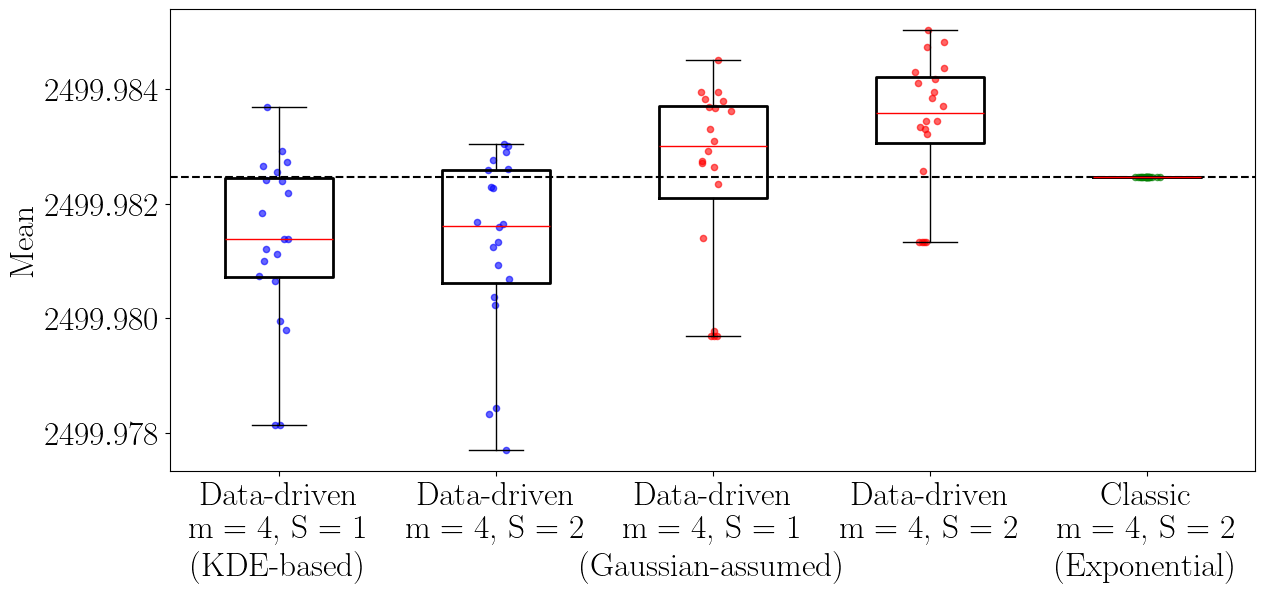

In [310]:
X_MCS = np.vstack([reshaped_x_true_list[i] for i in range(30)])
Y_MCS = Y(X_MCS)

plt.style.use('default')
plt.rcParams['text.usetex'] = True  # ← LaTeX 렌더링 활성화
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24


data = [exp_dd_gpce_mean_list_s1, exp_dd_gpce_mean_list, exp_c_gpce_mean_list_s1, exp_c_gpce_mean_list, exp_t_gpce_mean_list]
clipped_data = [clip_to_whisker(y) for y in data]
labels = [
    f'Data-driven' + '\n' + f'm = {m}, S = 1' +'\n'+'(KDE-based)',
    f'Data-driven' + '\n' + f'm = {m}, S = 2',
    f'Data-driven\nm = {m}, S = 1 \n (Gaussian-assumed)',
    f'Data-driven\nm = {m}, S = 2 ',
    f'Classic \nm = {m}, S = 2 \n (Exponential)'
    
]

# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)
ax.set_ylabel('Mean')
ax.axhline(np.mean(Y_MCS),color='black', linestyle='--', label='MCS mean')
# ax.legend(loc = 'upper left')
# plt.title('Box plot of mean values of DD-GPCE')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
print(np.mean(Y_MCS))


In [311]:
exp_dd_clipped_gpce_mean_error_list_s1 = np.abs((clipped_data[0] - np.mean(Y_MCS)))/np.mean(Y_MCS)*100
exp_dd_clipped_gpce_mean_error_list = np.abs((clipped_data[1] - np.mean(Y_MCS)))/np.mean(Y_MCS)*100
exp_c_clipped_gpce_mean_error_list_s1 = np.abs((clipped_data[2] - np.mean(Y_MCS)))/np.mean(Y_MCS)*100
exp_c_clipped_gpce_mean_error_list = np.abs((clipped_data[3] - np.mean(Y_MCS)))/np.mean(Y_MCS)*100
exp_t_clipped_gpce_mean_error_list = np.abs((clipped_data[4] - np.mean(Y_MCS)))/np.mean(Y_MCS)*100


In [312]:
# print min, max, mean relative error standard deviation (2 decimal places)
print("Data-driven GPCE(s1) mean error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(exp_dd_clipped_gpce_mean_error_list_s1),
    np.max(exp_dd_clipped_gpce_mean_error_list_s1),
    np.mean(exp_dd_clipped_gpce_mean_error_list_s1)
))

print("Data-driven GPCE mean error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(exp_dd_clipped_gpce_mean_error_list),
    np.max(exp_dd_clipped_gpce_mean_error_list),
    np.mean(exp_dd_clipped_gpce_mean_error_list)
))

print("Data-driven GPCE(s1) Gaussian assumed mean error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(exp_c_clipped_gpce_mean_error_list_s1),
    np.max(exp_c_clipped_gpce_mean_error_list_s1),
    np.mean(exp_c_clipped_gpce_mean_error_list_s1)
))

print("Data-driven GPCE Gaussian assumed mean error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(exp_c_clipped_gpce_mean_error_list),
    np.max(exp_c_clipped_gpce_mean_error_list),
    np.mean(exp_c_clipped_gpce_mean_error_list)
))

print("Classic GPCE Exponential mean error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(exp_t_clipped_gpce_mean_error_list),
    np.max(exp_t_clipped_gpce_mean_error_list),
    np.mean(exp_t_clipped_gpce_mean_error_list)
))

Data-driven GPCE(s1) mean error (%): min = 0.00000, max = 0.00017, mean = 0.00005
Data-driven GPCE mean error (%): min = 0.00000, max = 0.00019, mean = 0.00006
Data-driven GPCE(s1) Gaussian assumed mean error (%): min = 0.00000, max = 0.00011, mean = 0.00005
Data-driven GPCE Gaussian assumed mean error (%): min = 0.00000, max = 0.00010, mean = 0.00005
Classic GPCE Exponential mean error (%): min = 0.00000, max = 0.00000, mean = 0.00000


0.039710411323395985


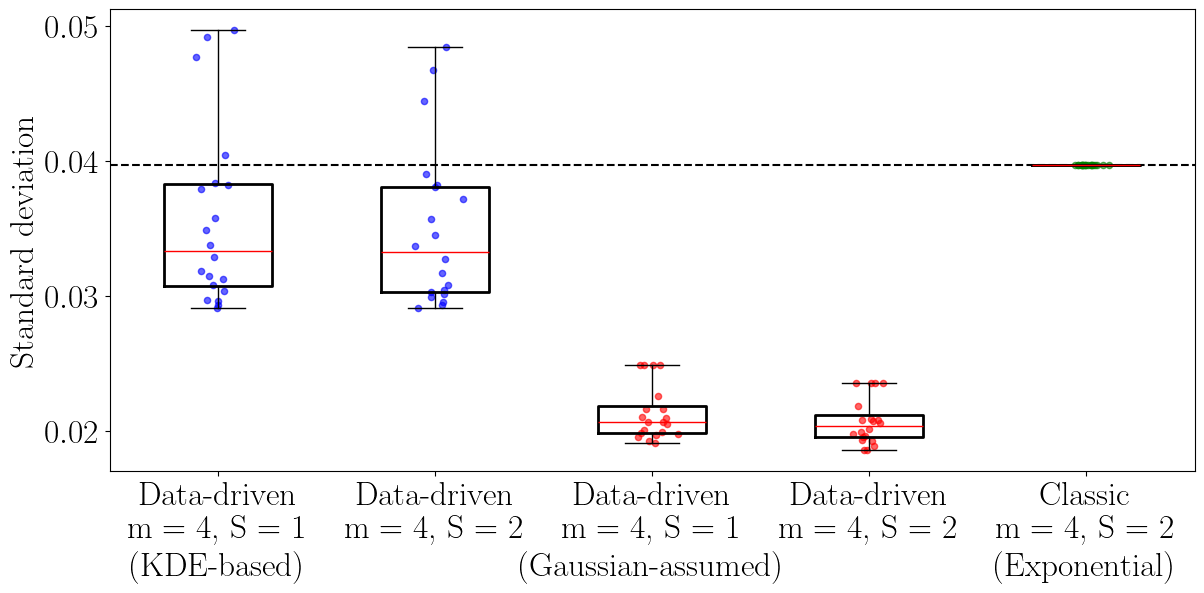

In [313]:
plt.style.use('default')
plt.rcParams['text.usetex'] = True  # ← LaTeX 렌더링 활성화
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24


data = [exp_dd_gpce_std_list_s1, exp_dd_gpce_std_list, exp_c_gpce_std_list_s1,exp_c_gpce_std_list, exp_t_gpce_std_list]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    f'Data-driven' + '\n' + f'm = {m}, S = 1' +'\n'+'(KDE-based)',
    f'Data-driven' + '\n' + f'm = {m}, S = 2',
    f'Data-driven\nm = {m}, S = 1 \n (Gaussian-assumed)',
    f'Data-driven\nm = {m}, S = 2 ',
    f'Classic \nm = {m}, S = 2 \n (Exponential)'
    
]

# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)
ax.set_ylabel('Standard deviation')
ax.axhline(np.std(Y_MCS),color='black', linestyle='--', label = 'MCS std')

# plt.title('Box plot of standard deviation values of DD-GPCE')
# ax.legend(loc = 'upper left')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
print(np.std(Y_MCS))

In [315]:
exp_dd_clipped_gpce_std_error_list_s1 = np.abs((clipped_data[0] - np.std(Y_MCS)))/np.std(Y_MCS)*100
exp_dd_clipped_gpce_std_error_list = np.abs((clipped_data[1] - np.std(Y_MCS)))/np.std(Y_MCS)*100
exp_c_clipped_gpce_std_error_list_s1 = np.abs((clipped_data[2] - np.std(Y_MCS)))/np.std(Y_MCS)*100
exp_c_clipped_gpce_std_error_list = np.abs((clipped_data[3] - np.std(Y_MCS)))/np.std(Y_MCS)*100
exp_t_clipped_gpce_std_error_list = np.abs((clipped_data[4] - np.std(Y_MCS)))/np.std(Y_MCS)*100

# print min, max, mean relative error standard deviation (2 decimal places)
print("Data-driven GPCE(s1) std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(exp_dd_clipped_gpce_std_error_list_s1),
    np.max(exp_dd_clipped_gpce_std_error_list_s1),
    np.mean(exp_dd_clipped_gpce_std_error_list_s1)
))

print("Data-driven GPCE std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(exp_dd_clipped_gpce_std_error_list),
    np.max(exp_dd_clipped_gpce_std_error_list),
    np.mean(exp_dd_clipped_gpce_std_error_list)
))

print("Data-driven GPCE(s1) Gaussian assumed std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(exp_c_clipped_gpce_std_error_list_s1),
    np.max(exp_c_clipped_gpce_std_error_list_s1),
    np.mean(exp_c_clipped_gpce_std_error_list_s1)
))

print("Data-driven GPCE Gaussian assumed std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(exp_c_clipped_gpce_std_error_list),
    np.max(exp_c_clipped_gpce_std_error_list),
    np.mean(exp_c_clipped_gpce_std_error_list)
))

print("Classic GPCE Exponential std error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(exp_t_clipped_gpce_std_error_list),
    np.max(exp_t_clipped_gpce_std_error_list),
    np.mean(exp_t_clipped_gpce_std_error_list)
))

Data-driven GPCE(s1) std error (%): min = 1.87, max = 26.70, mean = 17.36
Data-driven GPCE std error (%): min = 1.56, max = 26.66, mean = 16.98
Data-driven GPCE(s1) Gaussian assumed std error (%): min = 37.23, max = 51.80, mean = 46.27
Data-driven GPCE Gaussian assumed std error (%): min = 40.57, max = 53.26, mean = 47.88
Classic GPCE Exponential std error (%): min = 0.00001, max = 0.00001, mean = 0.00001


## Example 2: a ten-bar truss
### Case 1 ($\rho_{i,j} = 0$)

In [211]:
# Generate GPCE seed list
GPCE_seed_list = [105, 30, 127, 530, 160, 851, 566, 180, 77, 716, 119, 293, 451, 406, 844, 115, 363, 45, 450, 3216]

In [212]:
kde_sample_matrix_list = []
mean=[3.39]*10
std_dev = 0.14832396974
correlation_coefficient = 0
N = 10
covariance_matrix = compute_covariance_matrix(std_dev,correlation_coefficient,N)

for j in GPCE_seed_list:
    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = j))
    sample_number = 500000
    n_bootstrap = 100
    num_variables = 10
    kde_sample_matrix = np.zeros((num_variables, sample_number))

    for i in range(num_variables):
        kde_set = x_samples[:, [i]]
        # lim_min = np.mean(kde_set) - 5*np.std(kde_set)
        # lim_max = np.mean(kde_set) + 5*np.std(kde_set)
        lim_min = np.min(kde_set) - np.std(kde_set)
        lim_max = np.max(kde_set) + np.std(kde_set)
        x = np.mgrid[lim_min:lim_max:5000j]
        grid_coords = np.vstack([x.ravel()])
        # h = stats.gaussian_kde(kde_set.T, bw_method='scott').factor
        X = kde_set
        h = (X.shape[0] * (X.shape[1] + 2) / 4) ** (-1 / (X.shape[1] + 4)) # silverman rule of thumb
        kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
        kde_orign.fit(kde_set)
        kde_dens = kde_orign.score_samples(grid_coords.T)
        kde_dens = np.exp(kde_dens).reshape(x.shape[0])

        # Bootstrap bias correction
        n_bootstrap = 100
        boot_kdes = []
        n = len(x_samples[:, [0]])
        for _ in range(n_bootstrap):
            x_star = kde_set[np.random.choice(n, n, replace=True)]
            epsilon = np.random.normal(0, 0.1, size=n).reshape(-1, 1)
            x_plus = x_star + epsilon*h
            boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(x.shape[0]))
        boot_kdes = np.array(boot_kdes)


        bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)

        x_axes = np.linspace(lim_min, lim_max, 5000)
        # kde_sample1 = multivariate_inverse_transform_sampling(bias_corrected,[x_axes] ,n_samples=sample_number, seed=42456)
        kde_sample = inverse_transform_sampling(bias_corrected, 500000, x_axes, seed=GPCE_seed_list[i])
        kde_sample_matrix[i] = kde_sample
    kde_sample_matrix_list.append(kde_sample_matrix)

In [ ]:
# Load FEA results
YY = np.load('10_bar_FEA_Result.npy')
YU, YS = YY.T

mean=[3.39]*10
std_dev = 0.14832396974
correlation_coefficient = 0
N = 10
covariance_matrix = compute_covariance_matrix(std_dev,correlation_coefficient,N)

# Generate train sample sets
y_samples_list = []
x_samples_list = []
for i in GPCE_seed_list:
    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = i))
    Y_list = list(map(RSPSF_TRUSSf2, x_samples))
    y_samples = np.array(Y_list)
    y_samples_list.append(y_samples)
    x_samples_list.append(x_samples)
    x_true = np.exp(lhs_normal(500000, mean, covariance_matrix, seed = i))
    

In [214]:
# Data-driven DD-GPCE (m = 3, S = 1)
m = 3
S = 1
sample_number = 500000
YU_mean_relative_error_list = []
YS_mean_relative_error_list = []
YU_var_relative_error_list = []
YS_var_relative_error_list = []

D_GPCE_YS_mean_list = []
D_GPCE_YS_var_list = []
D_GPCE_YU_mean_list = []
D_GPCE_YU_var_list = []


for index, i in enumerate(kde_sample_matrix_list):
    kde_sample = i.T
    kde_sample_norm = kde_sample/np.mean(kde_sample, axis = 0)
    seed_index = GPCE_seed_list[index]
    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = seed_index))
    y_samples = y_samples_list[index]
    P = DD_GenP(kde_sample_norm, m, S)
    G = (P @ P.T) / sample_number
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q)


    P_t = DD_GenP(x_samples/np.mean(x_samples,axis=0),m,S)
    A = (W @ P_t).T

    B = y_samples.T[0]
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    B2 = y_samples.T[1]
    C2 = np.linalg.inv(A.T @ A) @ A.T @ B2

    D_GPCE_YU_mean = C[0]
    D_GPCE_YU_var = np.sum(C[1:]**2)

    Real_YU_mean = np.mean(YU)
    Real_YU_var = np.var(YU)

    D_GPCE_YS_mean = C2[0]
    D_GPCE_YS_var = np.sum(C2[1:]**2)

    Real_YS_mean = np.mean(YS)
    Real_YS_var = np.var(YS)

    YU_mean_relative_error = np.abs(D_GPCE_YU_mean - Real_YU_mean) / Real_YU_mean * 100
    YS_mean_relative_error = np.abs(D_GPCE_YS_mean - Real_YS_mean) / Real_YS_mean * 100
    YU_var_relative_error = np.abs(D_GPCE_YU_var - Real_YU_var) / Real_YU_var * 100
    YS_var_relative_error = np.abs(D_GPCE_YS_var - Real_YS_var) / Real_YS_var * 100

    YU_mean_relative_error_list.append(YU_mean_relative_error)
    YS_mean_relative_error_list.append(YS_mean_relative_error)
    YU_var_relative_error_list.append(YU_var_relative_error)
    YS_var_relative_error_list.append(YS_var_relative_error)

    D_GPCE_YU_mean_list.append(D_GPCE_YU_mean)
    D_GPCE_YU_var_list.append(D_GPCE_YU_var)
    D_GPCE_YS_mean_list.append(D_GPCE_YS_mean)
    D_GPCE_YS_var_list.append(D_GPCE_YS_var)


In [215]:
# Data-driven DD-GPCE (m = 2, S = 1)
m = 2
S = 1
sample_number = 500000
YU_mean_relative_error_list_m2 = []
YS_mean_relative_error_list_m2 = []
YU_var_relative_error_list_m2 = []
YS_var_relative_error_list_m2 = []

D_GPCE_YS_mean_list_m2 = []
D_GPCE_YS_var_list_m2 = []
D_GPCE_YU_mean_list_m2 = []
D_GPCE_YU_var_list_m2 = []

for index, i in enumerate(kde_sample_matrix_list):
    kde_sample = i.T
    kde_sample_norm = kde_sample/np.mean(kde_sample, axis = 0)
    seed_index = GPCE_seed_list[index]
    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = seed_index))
    y_samples = y_samples_list[index]
    P = DD_GenP(kde_sample_norm, m, S)
    G = (P @ P.T) / sample_number
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q)


    P_t = DD_GenP(x_samples/np.mean(x_samples,axis=0),m,S)
    A = (W @ P_t).T

    B = y_samples.T[0]
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    B2 = y_samples.T[1]
    C2 = np.linalg.inv(A.T @ A) @ A.T @ B2

    D_GPCE_YU_mean = C[0]
    D_GPCE_YU_var = np.sum(C[1:]**2)

    Real_YU_mean = np.mean(YU)
    Real_YU_var = np.var(YU)

    D_GPCE_YS_mean = C2[0]
    D_GPCE_YS_var = np.sum(C2[1:]**2)

    Real_YS_mean = np.mean(YS)
    Real_YS_var = np.var(YS)

    YU_mean_relative_error = np.abs(D_GPCE_YU_mean - Real_YU_mean) / Real_YU_mean * 100
    YS_mean_relative_error = np.abs(D_GPCE_YS_mean - Real_YS_mean) / Real_YS_mean * 100
    YU_var_relative_error = np.abs(D_GPCE_YU_var - Real_YU_var) / Real_YU_var * 100
    YS_var_relative_error = np.abs(D_GPCE_YS_var - Real_YS_var) / Real_YS_var * 100

    YU_mean_relative_error_list_m2.append(YU_mean_relative_error)
    YS_mean_relative_error_list_m2.append(YS_mean_relative_error)
    YU_var_relative_error_list_m2.append(YU_var_relative_error)
    YS_var_relative_error_list_m2.append(YS_var_relative_error)

    D_GPCE_YU_mean_list_m2.append(D_GPCE_YU_mean)
    D_GPCE_YU_var_list_m2.append(D_GPCE_YU_var)
    D_GPCE_YS_mean_list_m2.append(D_GPCE_YS_mean)
    D_GPCE_YS_var_list_m2.append(D_GPCE_YS_var)

In [216]:
# Gaussian-assumed DD-GPCE (m = 3, S = 1)
m = 3
S = 1
sample_number = 500000

C_YU_mean_relative_error_list = []
C_YS_mean_relative_error_list = []
C_YU_var_relative_error_list = []
C_YS_var_relative_error_list = []

C_GPCE_YS_mean_list = []
C_GPCE_YU_mean_list = []
C_GPCE_YS_var_list = []
C_GPCE_YU_var_list = []

for index, i  in enumerate(GPCE_seed_list):

    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = i))
    y_samples = y_samples_list[index]
    estimated_mean = np.mean(x_samples, axis=0)
    estimated_cov = np.cov(x_samples.T)
    estimated_samples = lhs_normal(500000, estimated_mean, estimated_cov, seed = i)
    estimated_samples_norm = estimated_samples/np.mean(estimated_samples,axis=0)

    P = DD_GenP(estimated_samples_norm, m, S)
    G = (P @ P.T) / sample_number
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q)


    P_t = DD_GenP(x_samples/np.mean(x_samples,axis=0),m,S)
    A = (W @ P_t).T

    B = y_samples.T[0]
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    B2 = y_samples.T[1]
    C2 = np.linalg.inv(A.T @ A) @ A.T @ B2

    C_GPCE_YU_mean = C[0]
    C_GPCE_YU_var = np.sum(C[1:]**2)

    Real_YU_mean = np.mean(YU)
    Real_YU_var = np.var(YU)

    C_GPCE_YS_mean = C2[0]
    C_GPCE_YS_var = np.sum(C2[1:]**2)

    Real_YS_mean = np.mean(YS)
    Real_YS_var = np.var(YS)

    C_YU_mean_relative_error = np.abs(C_GPCE_YU_mean - Real_YU_mean) / Real_YU_mean * 100
    C_YS_mean_relative_error = np.abs(C_GPCE_YS_mean - Real_YS_mean) / Real_YS_mean * 100
    C_YU_var_relative_error = np.abs(C_GPCE_YU_var - Real_YU_var) / Real_YU_var * 100
    C_YS_var_relative_error = np.abs(C_GPCE_YS_var - Real_YS_var) / Real_YS_var * 100

    C_YU_mean_relative_error_list.append(C_YU_mean_relative_error)
    C_YS_mean_relative_error_list.append(C_YS_mean_relative_error)
    C_YU_var_relative_error_list.append(C_YU_var_relative_error)
    C_YS_var_relative_error_list.append(C_YS_var_relative_error)

    C_GPCE_YU_mean_list.append(C_GPCE_YU_mean)
    C_GPCE_YU_var_list.append(C_GPCE_YU_var)
    C_GPCE_YS_mean_list.append(C_GPCE_YS_mean)
    C_GPCE_YS_var_list.append(C_GPCE_YS_var)

In [217]:
# Gaussian-assumed DD-GPCE (m = 2, S = 1)
m = 2
S = 1
sample_number = 500000

C_YU_mean_relative_error_list_m2 = []
C_YS_mean_relative_error_list_m2 = []
C_YU_var_relative_error_list_m2 = []
C_YS_var_relative_error_list_m2 = []

C_GPCE_YS_mean_list_m2 = []
C_GPCE_YU_mean_list_m2 = []
C_GPCE_YS_var_list_m2 = []
C_GPCE_YU_var_list_m2 = []

for index, i in enumerate(GPCE_seed_list):

    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = i))
    y_samples = y_samples_list[index]
    estimated_mean = np.mean(x_samples, axis=0)
    estimated_cov = np.cov(x_samples.T)
    estimated_samples = lhs_normal(500000, estimated_mean, estimated_cov, seed = i)
    estimated_samples_norm = estimated_samples/np.mean(estimated_samples,axis=0)

    P = DD_GenP(estimated_samples_norm, m, S)
    G = (P @ P.T) / sample_number
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q)


    P_t = DD_GenP(x_samples/np.mean(x_samples,axis=0),m,S)
    A = (W @ P_t).T

    B = y_samples.T[0]
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    B2 = y_samples.T[1]
    C2 = np.linalg.inv(A.T @ A) @ A.T @ B2

    C_GPCE_YU_mean = C[0]
    C_GPCE_YU_var = np.sum(C[1:]**2)

    Real_YU_mean = np.mean(YU)
    Real_YU_var = np.var(YU)

    C_GPCE_YS_mean = C2[0]
    C_GPCE_YS_var = np.sum(C2[1:]**2)

    Real_YS_mean = np.mean(YS)
    Real_YS_var = np.var(YS)

    C_YU_mean_relative_error = np.abs(C_GPCE_YU_mean - Real_YU_mean) / Real_YU_mean * 100
    C_YS_mean_relative_error = np.abs(C_GPCE_YS_mean - Real_YS_mean) / Real_YS_mean * 100
    C_YU_var_relative_error = np.abs(C_GPCE_YU_var - Real_YU_var) / Real_YU_var * 100
    C_YS_var_relative_error = np.abs(C_GPCE_YS_var - Real_YS_var) / Real_YS_var * 100

    C_YU_mean_relative_error_list_m2.append(C_YU_mean_relative_error)
    C_YS_mean_relative_error_list_m2.append(C_YS_mean_relative_error)
    C_YU_var_relative_error_list_m2.append(C_YU_var_relative_error)
    C_YS_var_relative_error_list_m2.append(C_YS_var_relative_error)

    C_GPCE_YU_mean_list_m2.append(C_GPCE_YU_mean)
    C_GPCE_YU_var_list_m2.append(C_GPCE_YU_var)
    C_GPCE_YS_mean_list_m2.append(C_GPCE_YS_mean)
    C_GPCE_YS_var_list_m2.append(C_GPCE_YS_var)


In [218]:
# Classic DD-GPCE (m = 3, S = 1)
m = 3
S = 1
sample_number = 500000

T_YU_mean_relative_error_list_m3 = []
T_YS_mean_relative_error_list_m3 = []
T_YU_var_relative_error_list_m3 = []
T_YS_var_relative_error_list_m3 = []

T_GPCE_YS_mean_list_m3 = []
T_GPCE_YU_mean_list_m3 = []
T_GPCE_YS_var_list_m3 = []
T_GPCE_YU_var_list_m3 = []

for index, i in enumerate(GPCE_seed_list):
    # P = DD_GenP(FP_bs_kde/np.mean(FP_bs_kde, axis = 0), m, S)
    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = i))
    y_samples = y_samples_list[index]

    x_true = np.exp(lhs_normal(500000, mean, covariance_matrix, seed = i))
    x_true_norm = x_true/np.mean(x_true, axis=0)

    P = DD_GenP(x_true_norm, m, S)
    G = (P @ P.T) / sample_number
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q)


    P_t = DD_GenP(x_samples/np.mean(x_samples,axis=0),m,S)
    A = (W @ P_t).T

    B = y_samples.T[0]
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    B2 = y_samples.T[1]
    C2 = np.linalg.inv(A.T @ A) @ A.T @ B2

    C_GPCE_YU_mean = C[0]
    C_GPCE_YU_var = np.sum(C[1:]**2)

    Real_YU_mean = np.mean(YU)
    Real_YU_var = np.var(YU)

    C_GPCE_YS_mean = C2[0]
    C_GPCE_YS_var = np.sum(C2[1:]**2)

    Real_YS_mean = np.mean(YS)
    Real_YS_var = np.var(YS)

    C_YU_mean_relative_error = np.abs(C_GPCE_YU_mean - Real_YU_mean) / Real_YU_mean * 100
    C_YS_mean_relative_error = np.abs(C_GPCE_YS_mean - Real_YS_mean) / Real_YS_mean * 100
    C_YU_var_relative_error = np.abs(C_GPCE_YU_var - Real_YU_var) / Real_YU_var * 100
    C_YS_var_relative_error = np.abs(C_GPCE_YS_var - Real_YS_var) / Real_YS_var * 100

    T_YU_mean_relative_error_list_m3.append(C_YU_mean_relative_error)
    T_YS_mean_relative_error_list_m3.append(C_YS_mean_relative_error)
    T_YU_var_relative_error_list_m3.append(C_YU_var_relative_error)
    T_YS_var_relative_error_list_m3.append(C_YS_var_relative_error)

    T_GPCE_YU_mean_list_m3.append(C_GPCE_YU_mean)
    T_GPCE_YU_var_list_m3.append(C_GPCE_YU_var)
    T_GPCE_YS_mean_list_m3.append(C_GPCE_YS_mean)
    T_GPCE_YS_var_list_m3.append(C_GPCE_YS_var)


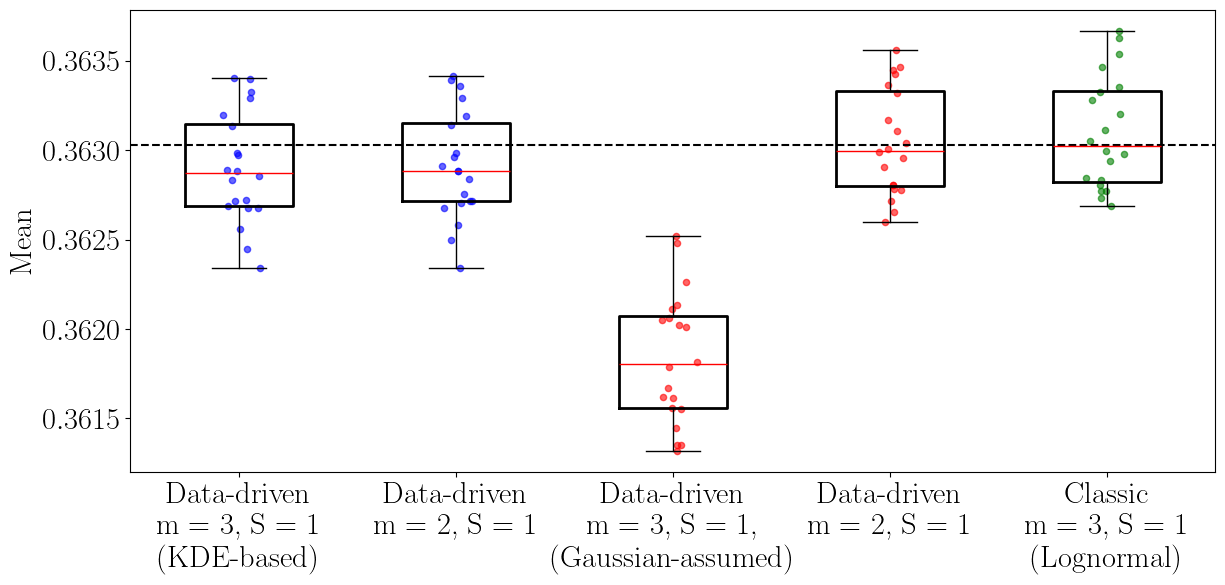

In [219]:
# YU mean boxplot

plt.style.use('default')
plt.rcParams['text.usetex'] = True  
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 22


data = [D_GPCE_YU_mean_list, D_GPCE_YU_mean_list_m2, C_GPCE_YU_mean_list, C_GPCE_YU_mean_list_m2, T_GPCE_YU_mean_list_m3]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 3, S = 1' + '\n' + r'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 2, S = 1',
    'Data-driven\nm = 3, S = 1, \n (Gaussian-assumed)',
    'Data-driven\nm = 2, S = 1',
    'Classic\nm = 3, S = 1 \n (Lognormal)',
]

# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)

    
ax.set_ylabel('Mean')
ax.axhline(np.mean(YU),color='black', linestyle='--', label = r'MCS $\mathbb{E}[y_1(\mathbf{X})]$')

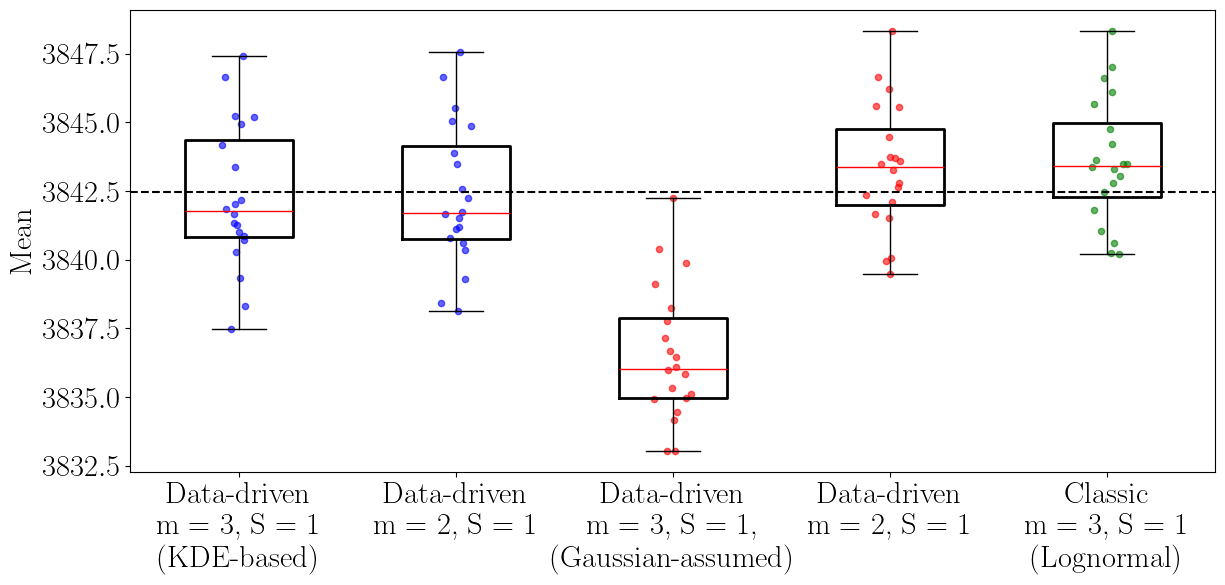

In [220]:
# YS mean boxplot
plt.style.use('default')
plt.rcParams['text.usetex'] = True  
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 22


data = [D_GPCE_YS_mean_list, D_GPCE_YS_mean_list_m2, C_GPCE_YS_mean_list, C_GPCE_YS_mean_list_m2, T_GPCE_YS_mean_list_m3]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 3, S = 1' + '\n' + r'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 2, S = 1',
    'Data-driven\nm = 3, S = 1, \n (Gaussian-assumed)',
    'Data-driven\nm = 2, S = 1',
    'Classic\nm = 3, S = 1 \n (Lognormal)',
]

# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)

    
ax.set_ylabel('Mean')
ax.axhline(np.mean(YS),color='black', linestyle='--', label = r'MCS $\mathbb{E}[y_2(\mathbf{X})]$')

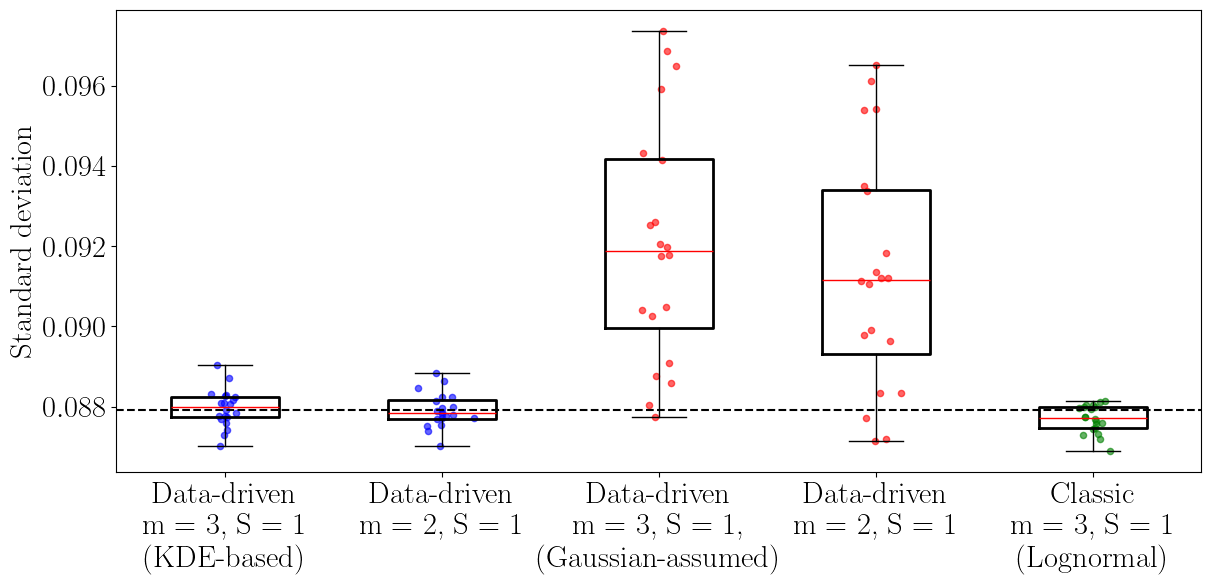

In [274]:
# YU standard deviation boxplot
plt.style.use('default')
plt.rcParams['text.usetex'] = True  
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 22


data = [np.sqrt(D_GPCE_YU_var_list), np.sqrt(D_GPCE_YU_var_list_m2), np.sqrt(C_GPCE_YU_var_list), np.sqrt(C_GPCE_YU_var_list_m2), np.sqrt(T_GPCE_YU_var_list_m3)]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 3, S = 1' + '\n' + r'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 2, S = 1',
    'Data-driven\nm = 3, S = 1, \n (Gaussian-assumed)',
    'Data-driven\nm = 2, S = 1',
    'Classic\nm = 3, S = 1 \n (Lognormal)',
]


# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red','green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)

    
# ax.set_ylabel('output var')
ax.set_ylabel(r'Standard deviation')
ax.axhline(np.std(YU),color='black', linestyle='--', label = r'MCS $\sigma_{y_1(\mathbf{X})}$')

In [275]:
D_GPCE_YU_clipped_gpce_std_error_list_m3 = np.abs((clipped_data[0] - np.std(YU)))/np.std(YU)*100
D_GPCE_YU_clipped_gpce_std_error_list_m2 = np.abs((clipped_data[1] - np.std(YU)))/np.std(YU)*100
C_GPCE_YU_clipped_gpce_std_error_list_m3 = np.abs((clipped_data[2] - np.std(YU)))/np.std(YU)*100
C_GPCE_YU_clipped_gpce_std_error_list_m2 = np.abs((clipped_data[3] - np.std(YU)))/np.std(YU)*100
T_GPCE_YU_clipped_gpce_std_error_list_m3 = np.abs((clipped_data[4] - np.std(YU)))/np.std(YU)*100

# print min, max, mean relative error standard deviation (2 decimal places)
print("Data-driven GPCE(m3) std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(D_GPCE_YU_clipped_gpce_std_error_list_m3),
    np.max(D_GPCE_YU_clipped_gpce_std_error_list_m3),
    np.mean(D_GPCE_YU_clipped_gpce_std_error_list_m3)
))

print("Data-driven GPCE std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(D_GPCE_YU_clipped_gpce_std_error_list_m2),
    np.max(D_GPCE_YU_clipped_gpce_std_error_list_m2),
    np.mean(D_GPCE_YU_clipped_gpce_std_error_list_m2)
))

print("Data-driven GPCE(m3) Gaussian assumed std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(C_GPCE_YU_clipped_gpce_std_error_list_m3),
    np.max(C_GPCE_YU_clipped_gpce_std_error_list_m3),
    np.mean(C_GPCE_YU_clipped_gpce_std_error_list_m3)
))

print("Data-driven GPCE Gaussian assumed std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(C_GPCE_YU_clipped_gpce_std_error_list_m2),
    np.max(C_GPCE_YU_clipped_gpce_std_error_list_m2),
    np.mean(C_GPCE_YU_clipped_gpce_std_error_list_m2)
))

print("Classic GPCE(m3) std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(T_GPCE_YU_clipped_gpce_std_error_list_m3),
    np.max(T_GPCE_YU_clipped_gpce_std_error_list_m3),
    np.mean(T_GPCE_YU_clipped_gpce_std_error_list_m3)
))

Data-driven GPCE(m3) std error (%): min = 0.02, max = 1.26, mean = 0.41
Data-driven GPCE std error (%): min = 0.04, max = 1.05, mean = 0.37
Data-driven GPCE(m3) Gaussian assumed std error (%): min = 0.12, max = 10.74, mean = 4.72
Data-driven GPCE Gaussian assumed std error (%): min = 0.24, max = 9.76, mean = 4.04
Classic GPCE(m3) std error (%): min = 0.01, max = 1.17, mean = 0.36


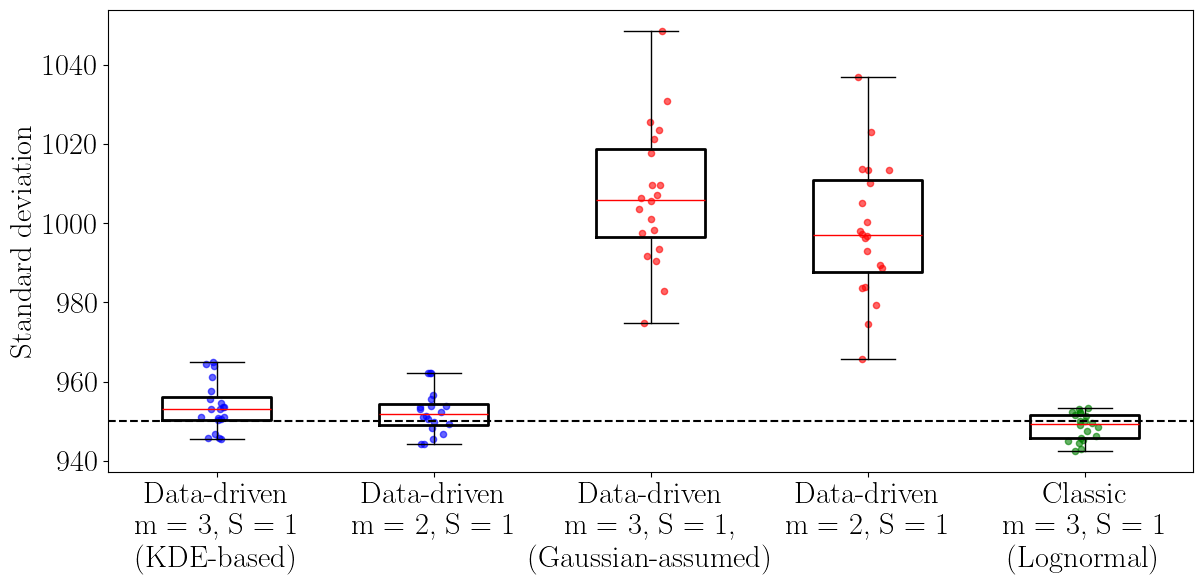

In [234]:
# YS standard deviation boxplot
plt.style.use('default')
plt.rcParams['text.usetex'] = True  
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 22


data = [np.sqrt(D_GPCE_YS_var_list), np.sqrt(D_GPCE_YS_var_list_m2), np.sqrt(C_GPCE_YS_var_list), np.sqrt(C_GPCE_YS_var_list_m2), np.sqrt(T_GPCE_YS_var_list_m3)]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 3, S = 1' + '\n' + r'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 2, S = 1',
    'Data-driven\nm = 3, S = 1, \n (Gaussian-assumed)',
    'Data-driven\nm = 2, S = 1',
    'Classic\nm = 3, S = 1 \n (Lognormal)',
]

# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)

    
ax.set_ylabel(r'Standard deviation')
ax.axhline(np.std(YS),color='black', linestyle='--', label = r'MCS $\sigma_{y_2(\mathbf{X})}$')

In [235]:
D_GPCE_YS_clipped_gpce_std_error_list_m3 = np.abs((clipped_data[0] - np.std(YS)))/np.std(YS)*100
D_GPCE_YS_clipped_gpce_std_error_list_m2 = np.abs((clipped_data[1] - np.std(YS)))/np.std(YS)*100
C_GPCE_YS_clipped_gpce_std_error_list_m3 = np.abs((clipped_data[2] - np.std(YS)))/np.std(YS)*100
C_GPCE_YS_clipped_gpce_std_error_list_m2 = np.abs((clipped_data[3] - np.std(YS)))/np.std(YS)*100
T_GPCE_YS_clipped_gpce_std_error_list_m3 = np.abs((clipped_data[4] - np.std(YS)))/np.std(YS)*100

# print min, max, mean relative error standard deviation (2 decimal places)
print("Data-driven GPCE(m3) std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(D_GPCE_YS_clipped_gpce_std_error_list_m3),
    np.max(D_GPCE_YS_clipped_gpce_std_error_list_m3),
    np.mean(D_GPCE_YS_clipped_gpce_std_error_list_m3)
))

print("Data-driven GPCE std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(D_GPCE_YS_clipped_gpce_std_error_list_m2),
    np.max(D_GPCE_YS_clipped_gpce_std_error_list_m2),
    np.mean(D_GPCE_YS_clipped_gpce_std_error_list_m2)
))

print("Data-driven GPCE(m3) Gaussian assumed std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(C_GPCE_YS_clipped_gpce_std_error_list_m3),
    np.max(C_GPCE_YS_clipped_gpce_std_error_list_m3),
    np.mean(C_GPCE_YS_clipped_gpce_std_error_list_m3)
))

print("Data-driven GPCE Gaussian assumed std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(C_GPCE_YS_clipped_gpce_std_error_list_m2),
    np.max(C_GPCE_YS_clipped_gpce_std_error_list_m2),
    np.mean(C_GPCE_YS_clipped_gpce_std_error_list_m2)
))

print("Classic GPCE(m3) std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(T_GPCE_YS_clipped_gpce_std_error_list_m3),
    np.max(T_GPCE_YS_clipped_gpce_std_error_list_m3),
    np.mean(T_GPCE_YS_clipped_gpce_std_error_list_m3)
))

Data-driven GPCE(m3) std error (%): min = 0.03, max = 1.56, mean = 0.56
Data-driven GPCE std error (%): min = 0.02, max = 1.28, mean = 0.47
Data-driven GPCE(m3) Gaussian assumed std error (%): min = 2.59, max = 10.36, mean = 5.99
Data-driven GPCE Gaussian assumed std error (%): min = 1.65, max = 9.14, mean = 5.06
Classic GPCE(m3) std error (%): min = 0.01, max = 0.79, mean = 0.31


### Case 2 ($\rho_{i,j} = 0.4$)

In [ ]:
GPCE_seed_list = [105, 30, 127, 530, 160, 851, 566, 180, 77, 716, 119, 293, 451, 406, 844, 115, 363, 45, 450, 3216]

In [106]:
# Generate MCS, train samples
mean=[3.39]*10
N = 10
std_dev = 0.14832396974
correlation_coefficient = 0.4
covariance_matrix = compute_covariance_matrix(std_dev,correlation_coefficient,N)

# Input samples
x_mcs = np.exp(lhs_normal(1000000, mean, covariance_matrix, seed = 4245))

# Output samples
Y_mcs_list = list(map(RSPSF_TRUSSf2, x_mcs))

cor_y_samples_list = []
for i in GPCE_seed_list:
    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = i))
    Y_list = list(map(RSPSF_TRUSSf2, x_samples))
    y_samples = np.array(Y_list)
    cor_y_samples_list.append(y_samples)

y_mcs = np.array(Y_mcs_list)
# Output extraction
YU_cor = y_mcs.T[0]
YS_cor = y_mcs.T[1]

Real_YU_mean = np.mean(YU_cor)
Real_YU_var = np.var(YU_cor)

Real_YS_mean = np.mean(YS_cor)
Real_YS_var = np.var(YS_cor)

In [ ]:
# Generate Monomial moment matrix (See section 3.1.1)

N = 10
m = 3
S = 1
variables = symbols(f'x:{N}')
P_all = sorted(itermonomials(variables, m), key=monomial_key('grlex', list(reversed(variables))))

# S=1에 해당하는 항만 추출
P = []
valid_indices = []

for i, mono in enumerate(P_all):
    mono_args = Mul.make_args(mono)
    if len(mono_args) <= S:
        P.append(mono)
        valid_indices.append(i)

P_matrix = Matrix(P)
G_symbolic = P_matrix * P_matrix.T  # symbolic (len(P) x len(P)) matrix
G_symbolic

# 샘플링
mean=[3.39]*10
std_dev = 0.14832396974
correlation_coefficient = 0.4
covariance_matrix = compute_covariance_matrix(std_dev,correlation_coefficient,N)
sam_num = 1000000

for seed in GPCE_seed_list:
    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed=seed))
    Y_list = list(map(RSPSF_TRUSSf2, x_samples))
    y_samples = np.array(Y_list)

    kde_cache = {}
    G_samples = {}

    for i in range(len(P)):
        for j in range(i, len(P)):  # upper triangle only
            expr = G_symbolic[i, j]
            var_indices = tuple(extract_variable_indices(expr, variables))
            if not var_indices:
                # 상수항일 경우 직접 계산
                G_samples[(i, j)] = 1  # 또는 scalar 1
                continue

            elif var_indices in kde_cache:
                samples = kde_cache[var_indices]
            else:
                reduced_samples = x_samples[:, var_indices]
                samples = kde_sampling(reduced_samples, sam_num)
                kde_cache[var_indices] = samples

            G_samples[(i, j)] = samples

    # 대칭성을 고려하여 (j, i) 쌍도 추가
    for (i,j), samples in list(G_samples.items()):
        if i != j:
            G_samples[(j,i)] = samples

    G_numeric = np.zeros((len(P), len(P)))

    for (i, j), samples in (G_samples.items()):
        expr = G_symbolic[i, j]

        # 상수항이면 그대로
        if isinstance(samples, (int, float, np.number)):
            G_numeric[i, j] = float(samples)
            continue

        # 바로 lambdify로 계산
        ordered_vars = sorted(expr.free_symbols, key=lambda x: str(x))
        func = lambdify(ordered_vars, expr, modules='numpy')
        evaluated = func(*samples.T)  # unpack axis-1 columns
        G_numeric[i, j] = np.mean(evaluated)

    # 대칭 복원
    for i in range(len(P)):
        for j in range(i+1, len(P)):
            G_numeric[j, i] = G_numeric[i, j]


In [ ]:
# Data-driven DD-GPCE (m = 3, S = 1)
m = 3
S = 1
sample_number = 1000000

cor_D_YU_mean_relative_error_list = []
cor_D_YS_mean_relative_error_list = []
cor_D_YU_std_relative_error_list = []
cor_D_YS_std_relative_error_list = []

cor_D_GPCE_YS_mean_list = []
cor_D_GPCE_YU_mean_list = []
cor_D_GPCE_YS_std_list = []
cor_D_GPCE_YU_std_list = []

for index, i  in enumerate(GPCE_seed_list):

    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = i))
    y_samples = cor_y_samples_list[index]

    G = np.load(f'DD_GPCE_G_values_3_1_silverman_million_1std_01eps_{i}.npy') 
   

    eigvals, eigvecs = np.linalg.eigh(G)
    eigvals_corrected = np.maximum(eigvals, 1e-14)
    G_posdef = eigvecs @ np.diag(eigvals_corrected) @ eigvecs.T
    Q = np.linalg.cholesky(G_posdef)
    W = np.linalg.inv(Q)


    P_t = DD_GenP(x_samples/np.mean(x_samples,axis=0),m,S)
    A = (W @ P_t).T

    B = y_samples.T[0]
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    B2 = y_samples.T[1]
    C2 = np.linalg.inv(A.T @ A) @ A.T @ B2

    C_GPCE_YU_mean = C[0]
    C_GPCE_YU_var = np.sum(C[1:]**2)
    C_GPCE_YU_std = np.sqrt(C_GPCE_YU_var)

    Real_YU_mean = np.mean(YU_cor)
    Real_YU_std = np.std(YU_cor)

    C_GPCE_YS_mean = C2[0]
    C_GPCE_YS_var = np.sum(C2[1:]**2)
    C_GPCE_YS_std = np.sqrt(C_GPCE_YS_var)

    Real_YS_mean = np.mean(YS_cor)
    Real_YS_std = np.std(YS_cor)

    C_YU_mean_relative_error = np.abs(C_GPCE_YU_mean - Real_YU_mean) / Real_YU_mean * 100
    C_YS_mean_relative_error = np.abs(C_GPCE_YS_mean - Real_YS_mean) / Real_YS_mean * 100
    C_YU_std_relative_error = np.abs(C_GPCE_YU_std - Real_YU_std) / Real_YU_std * 100
    C_YS_std_relative_error = np.abs(C_GPCE_YS_std - Real_YS_std) / Real_YS_std * 100

    cor_D_YU_mean_relative_error_list.append(C_YU_mean_relative_error)
    cor_D_YS_mean_relative_error_list.append(C_YS_mean_relative_error)
    cor_D_YU_std_relative_error_list.append(C_YU_std_relative_error)
    cor_D_YS_std_relative_error_list.append(C_YS_std_relative_error)

    cor_D_GPCE_YU_mean_list.append(C_GPCE_YU_mean)
    cor_D_GPCE_YU_std_list.append(C_GPCE_YU_std)
    cor_D_GPCE_YS_mean_list.append(C_GPCE_YS_mean)
    cor_D_GPCE_YS_std_list.append(C_GPCE_YS_std)


In [ ]:
# Data-driven DD-GPCE (m = 2, S = 1)
m = 2
S = 1
sample_number = 1000000

cor_D_YU_mean_relative_error_list_m2 = []
cor_D_YS_mean_relative_error_list_m2 = []
cor_D_YU_std_relative_error_list_m2 = []
cor_D_YS_std_relative_error_list_m2 = []

cor_D_GPCE_YS_mean_list_m2 = []
cor_D_GPCE_YU_mean_list_m2 = []
cor_D_GPCE_YS_std_list_m2 = []
cor_D_GPCE_YU_std_list_m2 = []

# 샘플링
mean=[3.39]*10
std_dev = 0.14832396974
correlation_coefficient = 0.4
covariance_matrix = compute_covariance_matrix(std_dev,correlation_coefficient,N)

for index, i  in enumerate(GPCE_seed_list):
    # P = DD_GenP(FP_bs_kde/np.mean(FP_bs_kde, axis = 0), m, S)
    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = i))
    y_samples = cor_y_samples_list[index]

    G = np.load(f'DD_GPCE_G_values_3_1_silverman_million_1std_01eps_{i}.npy') 
    variables = symbols(f'x:{N}')


    # 기존 G_numeric에서 해당 인덱스로 슬라이싱
    G_m2_S1_numeric = G[:21,:21]
    eigvals, eigvecs = np.linalg.eigh(G_m2_S1_numeric)
    eigvals_corrected = np.maximum(eigvals, 1e-14)
    G_posdef = eigvecs @ np.diag(eigvals_corrected) @ eigvecs.T
    Q = np.linalg.cholesky(G_posdef)
    W = np.linalg.inv(Q)


    P_t = DD_GenP(x_samples/np.mean(x_samples,axis=0),m,S)
    A = (W @ P_t).T

    B = y_samples.T[0]
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    B2 = y_samples.T[1]
    C2 = np.linalg.inv(A.T @ A) @ A.T @ B2

    C_GPCE_YU_mean = C[0]
    C_GPCE_YU_var = np.sum(C[1:]**2)
    C_GPCE_YU_std = np.sqrt(C_GPCE_YU_var)

    Real_YU_mean = np.mean(YU_cor)
    Real_YU_std = np.std(YU_cor)

    C_GPCE_YS_mean = C2[0]
    C_GPCE_YS_var = np.sum(C2[1:]**2)
    C_GPCE_YS_std = np.sqrt(C_GPCE_YS_var)

    Real_YS_mean = np.mean(YS_cor)
    Real_YS_std = np.std(YS_cor)

    C_YU_mean_relative_error = np.abs(C_GPCE_YU_mean - Real_YU_mean) / Real_YU_mean * 100
    C_YS_mean_relative_error = np.abs(C_GPCE_YS_mean - Real_YS_mean) / Real_YS_mean * 100
    C_YU_std_relative_error = np.abs(C_GPCE_YU_std - Real_YU_std) / Real_YU_std * 100
    C_YS_std_relative_error = np.abs(C_GPCE_YS_std - Real_YS_std) / Real_YS_std * 100

    cor_D_YU_mean_relative_error_list_m2.append(C_YU_mean_relative_error)
    cor_D_YS_mean_relative_error_list_m2.append(C_YS_mean_relative_error)
    cor_D_YU_std_relative_error_list_m2.append(C_YU_std_relative_error)
    cor_D_YS_std_relative_error_list_m2.append(C_YS_std_relative_error)

    cor_D_GPCE_YU_mean_list_m2.append(C_GPCE_YU_mean)
    cor_D_GPCE_YU_std_list_m2.append(C_GPCE_YU_std)
    cor_D_GPCE_YS_mean_list_m2.append(C_GPCE_YS_mean)
    cor_D_GPCE_YS_std_list_m2.append(C_GPCE_YS_std)


In [109]:
# Gaussian-assumed DD-GPCE (m = 3, S = 1)
m = 3
S = 1
sample_number = 1000000

cor_C_YU_mean_relative_error_list = []
cor_C_YS_mean_relative_error_list = []
cor_C_YU_std_relative_error_list = []
cor_C_YS_std_relative_error_list = []

cor_C_GPCE_YS_mean_list = []
cor_C_GPCE_YU_mean_list = []
cor_C_GPCE_YS_std_list = []
cor_C_GPCE_YU_std_list = []

for index, i  in enumerate(GPCE_seed_list):

    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = i))
    y_samples = cor_y_samples_list[index]
    estimated_mean = np.mean(x_samples, axis=0)
    estimated_cov = np.cov(x_samples.T)
    estimated_samples = lhs_normal(sample_number, estimated_mean, estimated_cov, seed = i)
    estimated_samples_norm = estimated_samples/np.mean(estimated_samples,axis=0)

    P = DD_GenP(estimated_samples_norm, m, S)
    G = (P @ P.T) / sample_number
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q)


    P_t = DD_GenP(x_samples/np.mean(x_samples,axis=0),m,S)
    A = (W @ P_t).T

    B = y_samples.T[0]
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    B2 = y_samples.T[1]
    C2 = np.linalg.inv(A.T @ A) @ A.T @ B2

    C_GPCE_YU_mean = C[0]
    C_GPCE_YU_var = np.sum(C[1:]**2)
    C_GPCE_YU_std = np.sqrt(C_GPCE_YU_var)

    Real_YU_mean = np.mean(YU_cor)
    Real_YU_std = np.std(YU_cor)

    C_GPCE_YS_mean = C2[0]
    C_GPCE_YS_var = np.sum(C2[1:]**2)
    C_GPCE_YS_std = np.sqrt(C_GPCE_YS_var)

    Real_YS_mean = np.mean(YS_cor)
    Real_YS_std = np.std(YS_cor)

    C_YU_mean_relative_error = np.abs(C_GPCE_YU_mean - Real_YU_mean) / Real_YU_mean * 100
    C_YS_mean_relative_error = np.abs(C_GPCE_YS_mean - Real_YS_mean) / Real_YS_mean * 100
    C_YU_std_relative_error = np.abs(C_GPCE_YU_std - Real_YU_std) / Real_YU_std * 100
    C_YS_std_relative_error = np.abs(C_GPCE_YS_std - Real_YS_std) / Real_YS_std * 100

    cor_C_YU_mean_relative_error_list.append(C_YU_mean_relative_error)
    cor_C_YS_mean_relative_error_list.append(C_YS_mean_relative_error)
    cor_C_YU_std_relative_error_list.append(C_YU_std_relative_error)
    cor_C_YS_std_relative_error_list.append(C_YS_std_relative_error)

    cor_C_GPCE_YU_mean_list.append(C_GPCE_YU_mean)
    cor_C_GPCE_YU_std_list.append(C_GPCE_YU_std)
    cor_C_GPCE_YS_mean_list.append(C_GPCE_YS_mean)
    cor_C_GPCE_YS_std_list.append(C_GPCE_YS_std)


In [110]:
# Gaussian-assumed DD-GPCE (m = 2, S = 1)
m = 2
S = 1
sample_number = 1000000

cor_C_YU_mean_relative_error_list_m2 = []
cor_C_YS_mean_relative_error_list_m2 = []
cor_C_YU_std_relative_error_list_m2 = []
cor_C_YS_std_relative_error_list_m2 = []

cor_C_GPCE_YS_mean_list_m2 = []
cor_C_GPCE_YU_mean_list_m2 = []
cor_C_GPCE_YS_std_list_m2 = []
cor_C_GPCE_YU_std_list_m2 = []

for index, i  in enumerate(GPCE_seed_list):
    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = i))
    y_samples = cor_y_samples_list[index]
    estimated_mean = np.mean(x_samples, axis=0)
    estimated_cov = np.cov(x_samples.T)
    estimated_samples = lhs_normal(sample_number, estimated_mean, estimated_cov, seed = i)
    estimated_samples_norm = estimated_samples/np.mean(estimated_samples,axis=0)

    P = DD_GenP(estimated_samples_norm, m, S)
    G = (P @ P.T) / sample_number
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q)


    P_t = DD_GenP(x_samples/np.mean(x_samples,axis=0),m,S)
    A = (W @ P_t).T

    B = y_samples.T[0]
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    B2 = y_samples.T[1]
    C2 = np.linalg.inv(A.T @ A) @ A.T @ B2

    C_GPCE_YU_mean = C[0]
    C_GPCE_YU_var = np.sum(C[1:]**2)
    C_GPCE_YU_std = np.sqrt(C_GPCE_YU_var)

    Real_YU_mean = np.mean(YU_cor)
    Real_YU_std = np.std(YU_cor)

    C_GPCE_YS_mean = C2[0]
    C_GPCE_YS_var = np.sum(C2[1:]**2)
    C_GPCE_YS_std = np.sqrt(C_GPCE_YS_var)

    Real_YS_mean = np.mean(YS_cor)
    Real_YS_std = np.std(YS_cor)

    C_YU_mean_relative_error = np.abs(C_GPCE_YU_mean - Real_YU_mean) / Real_YU_mean * 100
    C_YS_mean_relative_error = np.abs(C_GPCE_YS_mean - Real_YS_mean) / Real_YS_mean * 100
    C_YU_std_relative_error = np.abs(C_GPCE_YU_std - Real_YU_std) / Real_YU_std * 100
    C_YS_std_relative_error = np.abs(C_GPCE_YS_std - Real_YS_std) / Real_YS_std * 100

    cor_C_YU_mean_relative_error_list_m2.append(C_YU_mean_relative_error)
    cor_C_YS_mean_relative_error_list_m2.append(C_YS_mean_relative_error)
    cor_C_YU_std_relative_error_list_m2.append(C_YU_std_relative_error)
    cor_C_YS_std_relative_error_list_m2.append(C_YS_std_relative_error)

    cor_C_GPCE_YU_mean_list_m2.append(C_GPCE_YU_mean)
    cor_C_GPCE_YU_std_list_m2.append(C_GPCE_YU_std)
    cor_C_GPCE_YS_mean_list_m2.append(C_GPCE_YS_mean)
    cor_C_GPCE_YS_std_list_m2.append(C_GPCE_YS_std)


In [111]:
# Classic DD-GPCE (m = 3, S = 1)
m = 3
S = 1
sample_number = 1000000

cor_T_YU_mean_relative_error_list = []
cor_T_YS_mean_relative_error_list = []
cor_T_YU_std_relative_error_list = []
cor_T_YS_std_relative_error_list = []

cor_T_GPCE_YS_mean_list = []
cor_T_GPCE_YU_mean_list = []
cor_T_GPCE_YS_std_list = []
cor_T_GPCE_YU_std_list = []

for index, i  in enumerate(GPCE_seed_list):
    # P = DD_GenP(FP_bs_kde/np.mean(FP_bs_kde, axis = 0), m, S)
    x_samples = np.exp(lhs_normal(350, mean, covariance_matrix, seed = i))
    y_samples = cor_y_samples_list[index]
    x_true = np.exp(lhs_normal(1000000, mean, covariance_matrix, seed = i))
    x_true_norm = x_true/np.mean(x_true,axis=0)

    P = DD_GenP(x_true_norm, m, S)
    G = (P @ P.T) / sample_number
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q)


    P_t = DD_GenP(x_samples/np.mean(x_samples,axis=0),m,S)
    A = (W @ P_t).T

    B = y_samples.T[0]
    C = np.linalg.inv(A.T @ A) @ A.T @ B

    B2 = y_samples.T[1]
    C2 = np.linalg.inv(A.T @ A) @ A.T @ B2

    T_GPCE_YU_mean = C[0]
    T_GPCE_YU_var = np.sum(C[1:]**2)
    T_GPCE_YU_std = np.sqrt(T_GPCE_YU_var)

    Real_YU_mean = np.mean(YU_cor)
    Real_YU_std = np.std(YU_cor)

    T_GPCE_YS_mean = C2[0]
    T_GPCE_YS_var = np.sum(C2[1:]**2)
    T_GPCE_YS_std = np.sqrt(T_GPCE_YS_var)

    Real_YS_mean = np.mean(YS_cor)
    Real_YS_std = np.std(YS_cor)

    T_YU_mean_relative_error = np.abs(T_GPCE_YU_mean - Real_YU_mean) / Real_YU_mean * 100
    T_YS_mean_relative_error = np.abs(T_GPCE_YS_mean - Real_YS_mean) / Real_YS_mean * 100
    T_YU_std_relative_error = np.abs(T_GPCE_YU_std - Real_YU_std) / Real_YU_std * 100
    T_YS_std_relative_error = np.abs(T_GPCE_YS_std - Real_YS_std) / Real_YS_std * 100

    cor_T_YU_mean_relative_error_list.append(T_YU_mean_relative_error)
    cor_T_YS_mean_relative_error_list.append(T_YS_mean_relative_error)
    cor_T_YU_std_relative_error_list.append(T_YU_std_relative_error)
    cor_T_YS_std_relative_error_list.append(T_YS_std_relative_error)

    cor_T_GPCE_YU_mean_list.append(T_GPCE_YU_mean)
    cor_T_GPCE_YU_std_list.append(T_GPCE_YU_std)
    cor_T_GPCE_YS_mean_list.append(T_GPCE_YS_mean)
    cor_T_GPCE_YS_std_list.append(T_GPCE_YS_std)


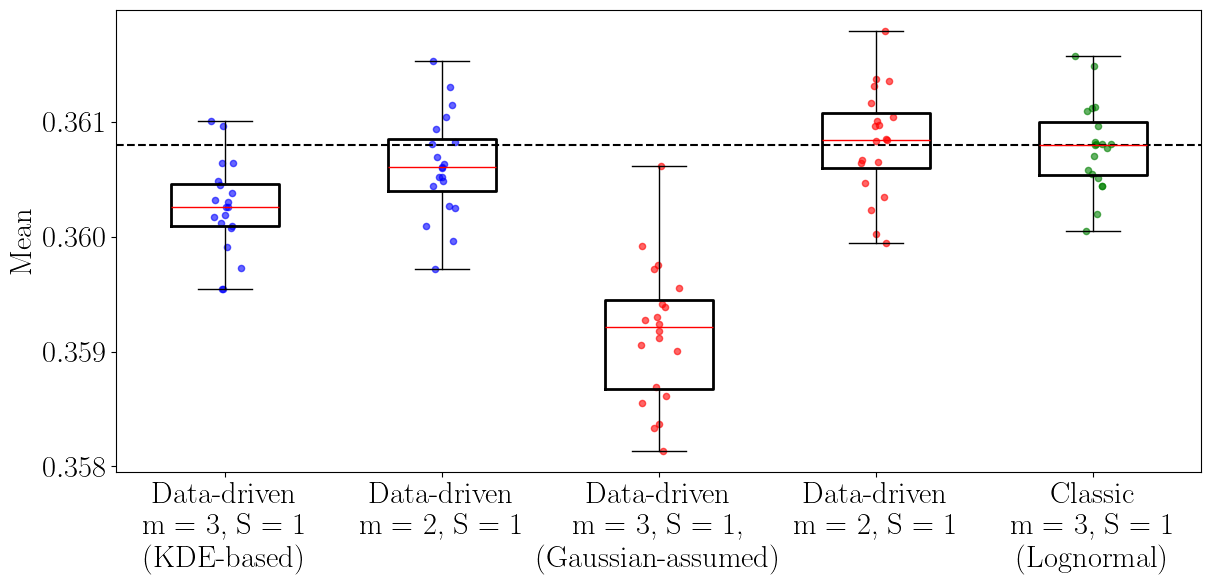

In [277]:
# YU mean boxplot

plt.style.use('default')
plt.rcParams['text.usetex'] = True  
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 22


data = [cor_D_GPCE_YU_mean_list, cor_D_GPCE_YU_mean_list_m2, cor_C_GPCE_YU_mean_list, cor_C_GPCE_YU_mean_list_m2, cor_T_GPCE_YU_mean_list]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 3, S = 1' + '\n' + r'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 2, S = 1',
    'Data-driven\nm = 3, S = 1, \n (Gaussian-assumed)',
    'Data-driven\nm = 2, S = 1',
    'Classic\nm = 3, S = 1 \n (Lognormal)',
]


# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red','green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)

    
# ax.set_ylabel('output var')
ax.set_ylabel(r'Mean')
ax.axhline(np.mean(YU_cor),color='black', linestyle='--', label = r'MCS $\sigma_{y_1(\mathbf{X})}$')

In [279]:
cor_D_YU_clipped_gpce_mean_error_list_m3 = np.abs((clipped_data[0] - np.mean(YU_cor)))/np.mean(YU_cor)*100
cor_D_YU_clipped_gpce_mean_error_list_m2 = np.abs((clipped_data[1] - np.mean(YU_cor)))/np.mean(YU_cor)*100
cor_C_YU_clipped_gpce_mean_error_list_m3 = np.abs((clipped_data[2] - np.mean(YU_cor)))/np.mean(YU_cor)*100
cor_C_YU_clipped_gpce_mean_error_list_m2 = np.abs((clipped_data[3] - np.mean(YU_cor)))/np.mean(YU_cor)*100
cor_T_YU_clipped_gpce_mean_error_list_m3 = np.abs((clipped_data[4] - np.mean(YU_cor)))/np.mean(YU_cor)*100

# print min, max, mean relative error mean (2 decimal places)
print("Data-driven GPCE(m3) mean error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_D_YU_clipped_gpce_mean_error_list_m3),
    np.max(cor_D_YU_clipped_gpce_mean_error_list_m3),
    np.mean(cor_D_YU_clipped_gpce_mean_error_list_m3)
))

print("Data-driven GPCE mean error (%): min = {:.5f}, max = {:.5f}, mean = {:.5f}".format(
    np.min(cor_D_YU_clipped_gpce_mean_error_list_m2),
    np.max(cor_D_YU_clipped_gpce_mean_error_list_m2),
    np.mean(cor_D_YU_clipped_gpce_mean_error_list_m2)
))

print("Data-driven GPCE(m3) Gaussian assumed mean error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_C_YU_clipped_gpce_mean_error_list_m3),
    np.max(cor_C_YU_clipped_gpce_mean_error_list_m3),
    np.mean(cor_C_YU_clipped_gpce_mean_error_list_m3)
))

print("Data-driven GPCE Gaussian assumed mean error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_C_YU_clipped_gpce_mean_error_list_m2),
    np.max(cor_C_YU_clipped_gpce_mean_error_list_m2),
    np.mean(cor_C_YU_clipped_gpce_mean_error_list_m2)
))

print("Classic GPCE(m3) mean error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_T_YU_clipped_gpce_mean_error_list_m3),
    np.max(cor_T_YU_clipped_gpce_mean_error_list_m3),
    np.mean(cor_T_YU_clipped_gpce_mean_error_list_m3)
))

Data-driven GPCE(m3) mean error (%): min = 0.04, max = 0.35, mean = 0.16
Data-driven GPCE mean error (%): min = 0.00062, max = 0.30133, mean = 0.10543
Data-driven GPCE(m3) Gaussian assumed mean error (%): min = 0.05, max = 0.74, mean = 0.46
Data-driven GPCE Gaussian assumed mean error (%): min = 0.01, max = 0.27, mean = 0.10
Classic GPCE(m3) mean error (%): min = 0.00, max = 0.21, mean = 0.08


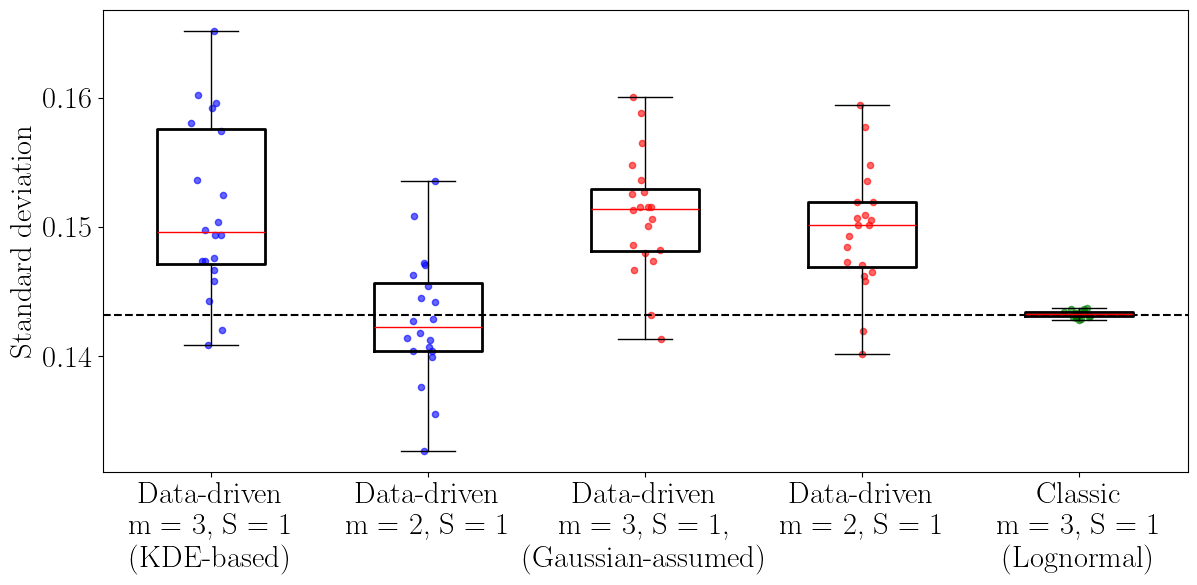

In [228]:
# YU standard deviation boxplot

plt.style.use('default')
plt.rcParams['text.usetex'] = True  
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 22


data = [cor_D_GPCE_YU_std_list, cor_D_GPCE_YU_std_list_m2, cor_C_GPCE_YU_std_list,cor_C_GPCE_YU_std_list_m2, cor_T_GPCE_YU_std_list]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 3, S = 1' + '\n' + r'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 2, S = 1',
    'Data-driven\nm = 3, S = 1, \n (Gaussian-assumed)',
    'Data-driven\nm = 2, S = 1',
    'Classic\nm = 3, S = 1 \n (Lognormal)',
]


# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red','green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)

    
# ax.set_ylabel('output var')
ax.set_ylabel(r'Standard deviation')
ax.axhline(np.std(YU_cor),color='black', linestyle='--', label = r'MCS $\sigma_{y_1(\mathbf{X})}$')

In [229]:
cor_D_YU_clipped_gpce_std_error_list_s1 = np.abs((clipped_data[0] - np.std(YU_cor)))/np.std(YU_cor)*100
cor_D_YU_clipped_gpce_std_error_list = np.abs((clipped_data[1] - np.std(YU_cor)))/np.std(YU_cor)*100
cor_C_YU_clipped_gpce_std_error_list_s1 = np.abs((clipped_data[2] - np.std(YU_cor)))/np.std(YU_cor)*100
cor_C_YU_clipped_gpce_std_error_list = np.abs((clipped_data[3] - np.std(YU_cor)))/np.std(YU_cor)*100
cor_T_YU_clipped_gpce_std_error_list = np.abs((clipped_data[4] - np.std(YU_cor)))/np.std(YU_cor)*100

# print min, max, mean relative error standard deviation (2 decimal places)
print("Data-driven GPCE(s1) std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_D_YU_clipped_gpce_std_error_list_s1),
    np.max(cor_D_YU_clipped_gpce_std_error_list_s1),
    np.mean(cor_D_YU_clipped_gpce_std_error_list_s1)
))

print("Data-driven GPCE std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_D_YU_clipped_gpce_std_error_list),
    np.max(cor_D_YU_clipped_gpce_std_error_list),
    np.mean(cor_D_YU_clipped_gpce_std_error_list)
))

print("Data-driven GPCE(s1) Gaussian assumed std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_C_YU_clipped_gpce_std_error_list_s1),
    np.max(cor_C_YU_clipped_gpce_std_error_list_s1),
    np.mean(cor_C_YU_clipped_gpce_std_error_list_s1)
))

print("Data-driven GPCE Gaussian assumed std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_C_YU_clipped_gpce_std_error_list),
    np.max(cor_C_YU_clipped_gpce_std_error_list),
    np.mean(cor_C_YU_clipped_gpce_std_error_list)
))

print("Classic GPCE std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_T_YU_clipped_gpce_std_error_list),
    np.max(cor_T_YU_clipped_gpce_std_error_list),
    np.mean(cor_T_YU_clipped_gpce_std_error_list)
))

Data-driven GPCE(s1) std error (%): min = 0.77, max = 15.40, mean = 5.96
Data-driven GPCE std error (%): min = 0.22, max = 7.34, mean = 2.61
Data-driven GPCE(s1) Gaussian assumed std error (%): min = 0.00, max = 11.82, mean = 5.58
Data-driven GPCE Gaussian assumed std error (%): min = 0.82, max = 11.38, mean = 4.89
Classic GPCE std error (%): min = 0.01, max = 0.42, mean = 0.15


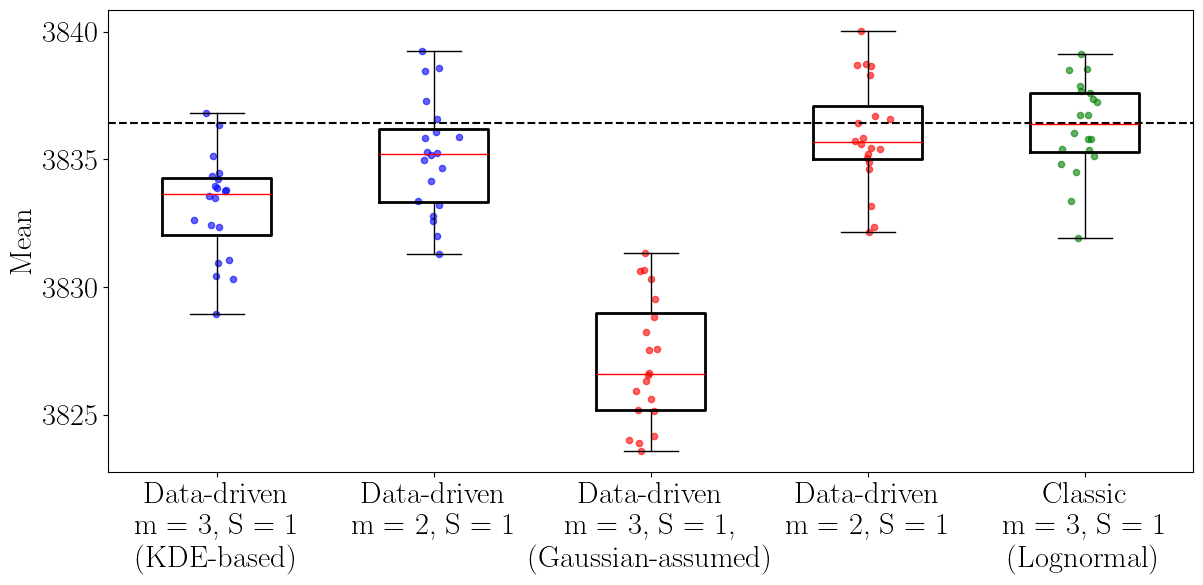

In [166]:
# YS mean boxplot

plt.style.use('default')
plt.rcParams['text.usetex'] = True  
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 22


data = [cor_D_GPCE_YS_mean_list, cor_D_GPCE_YS_mean_list_m2, cor_C_GPCE_YS_mean_list, cor_C_GPCE_YS_mean_list_m2, cor_T_GPCE_YS_mean_list]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 3, S = 1' + '\n' + r'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 2, S = 1',
    'Data-driven\nm = 3, S = 1, \n (Gaussian-assumed)',
    'Data-driven\nm = 2, S = 1',
    'Classic\nm = 3, S = 1 \n (Lognormal)',
]


# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red','green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)

    
# ax.set_ylabel('output var')
ax.set_ylabel(r'Mean')
ax.axhline(np.mean(YS_cor),color='black', linestyle='--', label = r'MCS $\sigma_{y_1(\mathbf{X})}$')

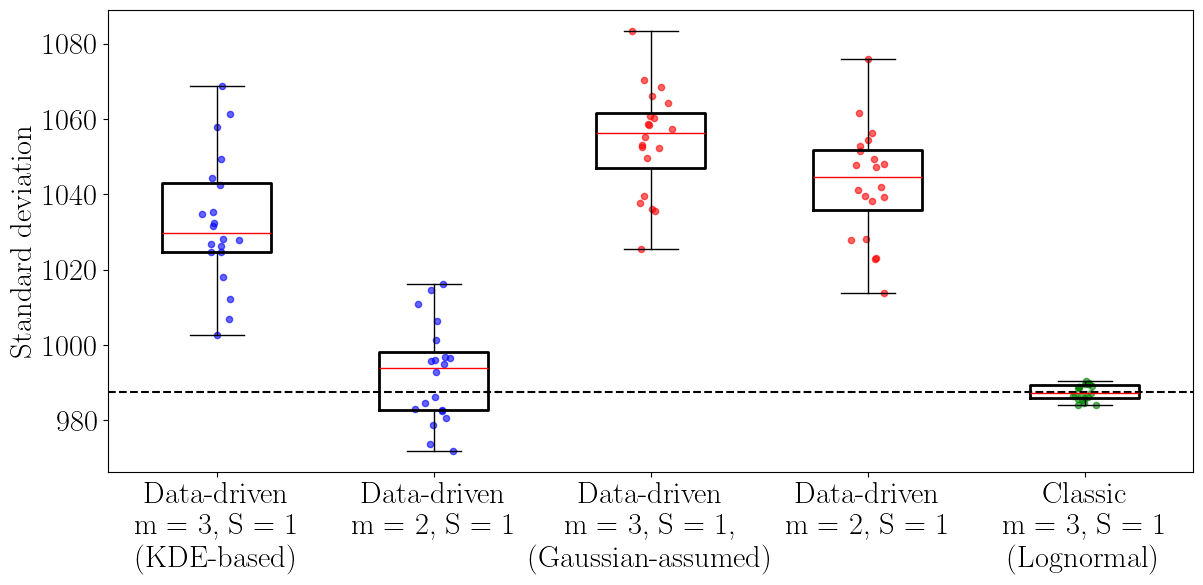

In [231]:
# YS standard deviation boxplot

plt.style.use('default')
plt.rcParams['text.usetex'] = True  
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 22


data = [cor_D_GPCE_YS_std_list, cor_D_GPCE_YS_std_list_m2, cor_C_GPCE_YS_std_list, cor_C_GPCE_YS_std_list_m2, cor_T_GPCE_YS_std_list]
clipped_data = [clip_to_whisker(np.array(y)) for y in data]
labels = [
    r'Data-driven' + '\n' + r'm = 3, S = 1' + '\n' + r'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 2, S = 1',
    'Data-driven\nm = 3, S = 1, \n (Gaussian-assumed)',
    'Data-driven\nm = 2, S = 1',
    'Classic\nm = 3, S = 1 \n (Lognormal)',
]


# boxplot
fig, ax = plt.subplots()
boxprops = dict(linestyle = '-', linewidth = 2, color = 'k')
medianprops = dict(linestyle = '-', linewidth = 1, color = 'r')
ax.boxplot(clipped_data,labels=labels, boxprops=boxprops, medianprops=medianprops)


# scatter plot
colors = ['blue', 'blue', 'red', 'red','green']
for i, (y,color) in enumerate(zip(clipped_data, colors), start = 1 ):
    x = np.random.normal(i, 0.04, size = len(y))
    ax.scatter(x,y,alpha = 0.6, color = color, s = 20)

    
# ax.set_ylabel('output var')
ax.set_ylabel(r'Standard deviation')
ax.axhline(np.std(YS_cor),color='black', linestyle='--', label = r'MCS $\sigma_{y_1(\mathbf{X})}$')

# plt.title('Box plot of standard deviation values of DD-GPCE')
# ax.legend(loc = 'upper left')
# plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

In [232]:
cor_D_YS_clipped_gpce_std_error_list_m3 = np.abs((clipped_data[0] - np.std(YS_cor)))/np.std(YS_cor)*100
cor_D_YS_clipped_gpce_std_error_list_m2 = np.abs((clipped_data[1] - np.std(YS_cor)))/np.std(YS_cor)*100
cor_C_YS_clipped_gpce_std_error_list_m3 = np.abs((clipped_data[2] - np.std(YS_cor)))/np.std(YS_cor)*100
cor_C_YS_clipped_gpce_std_error_list_m2 = np.abs((clipped_data[3] - np.std(YS_cor)))/np.std(YS_cor)*100
cor_T_YS_clipped_gpce_std_error_list_m3 = np.abs((clipped_data[4] - np.std(YS_cor)))/np.std(YS_cor)*100

# print min, max, mean relative error standard deviation (2 decimal places)
print("Data-driven GPCE(m3) std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_D_YS_clipped_gpce_std_error_list_m3),
    np.max(cor_D_YS_clipped_gpce_std_error_list_m3),
    np.mean(cor_D_YS_clipped_gpce_std_error_list_m3)
))

print("Data-driven GPCE std error(m2) (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_D_YS_clipped_gpce_std_error_list_m2),
    np.max(cor_D_YS_clipped_gpce_std_error_list_m2),
    np.mean(cor_D_YS_clipped_gpce_std_error_list_m2)
))

print("Data-driven GPCE(m3) Gaussian assumed std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_C_YS_clipped_gpce_std_error_list_m3),
    np.max(cor_C_YS_clipped_gpce_std_error_list_m3),
    np.mean(cor_C_YS_clipped_gpce_std_error_list_m3)
))

print("Data-driven GPCE(m2) Gaussian assumed std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_C_YS_clipped_gpce_std_error_list_m2),
    np.max(cor_C_YS_clipped_gpce_std_error_list_m2),
    np.mean(cor_C_YS_clipped_gpce_std_error_list_m2)
))

print("Classic GPCE(m3) std error (%): min = {:.2f}, max = {:.2f}, mean = {:.2f}".format(
    np.min(cor_T_YS_clipped_gpce_std_error_list_m3),
    np.max(cor_T_YS_clipped_gpce_std_error_list_m3),
    np.mean(cor_T_YS_clipped_gpce_std_error_list_m3)
))

Data-driven GPCE(m3) std error (%): min = 1.54, max = 8.22, mean = 4.59
Data-driven GPCE std error(m2) (%): min = 0.14, max = 2.89, mean = 1.13
Data-driven GPCE(m3) Gaussian assumed std error (%): min = 3.84, max = 9.71, mean = 6.76
Data-driven GPCE(m2) Gaussian assumed std error (%): min = 2.66, max = 8.94, mean = 5.62
Classic GPCE(m3) std error (%): min = 0.02, max = 0.35, mean = 0.18


# DA-20

In [116]:
# Import MCS modal frequency

file_path = 'C:/Users/HojunChoi/Desktop/최호준/연구자료/논문/수학예제 결과/DA-20/Y_result_1000.csv'

df = pd.read_csv(file_path)
df = df.drop(columns='index')
YY = df.to_numpy(float)

In [118]:
# Import MCS modal frequency

file_path = 'C:/Users/HojunChoi/Desktop/최호준/연구자료/논문/수학예제 결과/DA-20/X_value_1000.csv'

df = pd.read_csv(file_path)
df = df.drop(columns='index')
XX = df.to_numpy(float)

In [152]:
sample_number = 2000000
mean_log_normal1 = np.array([     1,             1,             1,         1,           1,         1,         1])

std_log_normal1  = np.array([  0.06,          0.06,          0.06,      0.06,        0.06,      0.06,      0.06])

ln_X1 = sampling(mean_log_normal1, std_log_normal1**2, 0.5, sample_number, 76543)
X1 = np.exp(ln_X1)

mean_log_normal2 = np.array([451.241, 75.287, 196.370, 30.614,  441000000000,  167000000000,      0.32,        1870, 207000000, 207000000, 586000000,   15.1,     480])

std_log_normal2  = np.array([ 27.075, 5,  9.8, 1.5,    22050000000,     8350000000,     0.016,     93.5,  10350000, 10350000,  29300000,     0.7,     24])

ln_X2 = sampling(mean_log_normal2, std_log_normal2**2, 0, sample_number, 76543)
X2 = np.exp(ln_X2)

XX_MCS = np.concatenate((X1, X2), axis=1)


In [153]:
kde1 = stats.gaussian_kde((XX[:, [0,1,2,3,4,5,6]]).T, bw_method='silverman').resample(2000000, seed = 4322).T

In [155]:
# 8 ~ 11
sample_number = 2000000
seed = 456789
num_variables = 4
kde_sample_matrix1 = np.zeros((num_variables, sample_number))
eps = 0.1
for i in range(num_variables):
    kde_set = XX[:, [i + 7]]
    # kde_set = kde_sett/np.mean(kde_sett)
    lim_min = np.min(kde_set) - np.std(kde_set)
    lim_max = np.max(kde_set) + np.std(kde_set)
    x = np.mgrid[lim_min:lim_max:5000j]
    grid_coords = np.vstack([x.ravel()])
    # h = stats.gaussian_kde(kde_set.T, bw_method='scott').factor
    # h = silverman(kde_set)
    n, d = kde_set.shape
    h = (4/(d+2))**(1/(d+4))*n**(-1/(d+4))
    kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_orign.fit(kde_set)
    kde_dens = kde_orign.score_samples(grid_coords.T)
    kde_dens = np.exp(kde_dens).reshape(x.shape[0])

    # Bootstrap bias correction
    n_bootstrap = 100
    boot_kdes = []
    n = len(kde_set)
    for _ in range(n_bootstrap):
        x_star = kde_set[np.random.choice(n, n, replace=True)]
        epsilon = np.random.normal(0, eps, size=n).reshape(-1, 1)
        x_plus = x_star + epsilon*h
        boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(x.shape[0]))
    boot_kdes = np.array(boot_kdes)


    bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)

    x_axes = np.linspace(lim_min, lim_max, 5000)
    # kde_sample1 = multivariate_inverse_transform_sampling(bias_corrected,[x_axes] ,n_samples=sample_number, seed=42456)
    kde_sample = inverse_transform_sampling(bias_corrected, sample_number, x_axes, seed=seed)
    kde_sample_matrix1[i] = kde_sample

In [156]:
# 12, 13
sample_number = 2000000
seed = 456789
num_variables = 2
eps = 0.1
kde_sample_matrix2 = np.zeros((num_variables, sample_number))
for i in range(num_variables):
    kde_set = XX[:, [i + 11]]/1e10
    # kde_set = kde_sett/np.mean(kde_sett)
    lim_min = np.min(kde_set) - np.std(kde_set)
    lim_max = np.max(kde_set) + np.std(kde_set)
    x = np.mgrid[lim_min:lim_max:5000j]
    grid_coords = np.vstack([x.ravel()])
    # h = stats.gaussian_kde(kde_set.T, bw_method='scott').factor
    # h = silverman(kde_set)
    n, d = kde_set.shape
    h = (4/(d+2))**(1/(d+4))*n**(-1/(d+4))
    kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_orign.fit(kde_set)
    kde_dens = kde_orign.score_samples(grid_coords.T)
    kde_dens = np.exp(kde_dens).reshape(x.shape[0])

    # Bootstrap bias correction
    n_bootstrap = 100
    boot_kdes = []
    n = len(kde_set)
    for _ in range(n_bootstrap):
        x_star = kde_set[np.random.choice(n, n, replace=True)]
        epsilon = np.random.normal(0, eps, size=n).reshape(-1, 1)
        x_plus = x_star + epsilon*h
        boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(x.shape[0]))
    boot_kdes = np.array(boot_kdes)


    bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)

    x_axes = np.linspace(lim_min, lim_max, 5000)
    # kde_sample1 = multivariate_inverse_transform_sampling(bias_corrected,[x_axes] ,n_samples=sample_number, seed=42456)
    kde_sample = inverse_transform_sampling(bias_corrected, sample_number, x_axes, seed=seed)*1e10
    kde_sample_matrix2[i] = kde_sample

In [157]:
# 14, 15
sample_number = 2000000
seed = 456789
num_variables = 2
kde_sample_matrix3 = np.zeros((num_variables, sample_number))
for i in range(num_variables):
    kde_set = XX[:, [i + 13]]
    # kde_set = kde_sett/np.mean(kde_sett)
    lim_min = np.min(kde_set) - np.std(kde_set)
    lim_max = np.max(kde_set) + np.std(kde_set)
    x = np.mgrid[lim_min:lim_max:5000j]
    grid_coords = np.vstack([x.ravel()])
    # h = stats.gaussian_kde(kde_set.T, bw_method='scott').factor
    # h = silverman(kde_set)
    n, d = kde_set.shape
    if i == 0:
        h = (4/(d+2))**(1/(d+4))*n**(-1/(d+4))*np.std(kde_set)
    else:
        h = (4/(d+2))**(1/(d+4))*n**(-1/(d+4))
    kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_orign.fit(kde_set)
    kde_dens = kde_orign.score_samples(grid_coords.T)
    kde_dens = np.exp(kde_dens).reshape(x.shape[0])
    eps_set = [0.1, 0.1]
    # Bootstrap bias correction
    n_bootstrap = 100
    boot_kdes = []
    n = len(kde_set)
    for _ in range(n_bootstrap):
        x_star = kde_set[np.random.choice(n, n, replace=True)]
        epsilon = np.random.normal(0, eps_set[i], size=n).reshape(-1, 1)
        x_plus = x_star + epsilon*h
        boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(x.shape[0]))
    boot_kdes = np.array(boot_kdes)


    bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)

    x_axes = np.linspace(lim_min, lim_max, 5000)
    # kde_sample1 = multivariate_inverse_transform_sampling(bias_corrected,[x_axes] ,n_samples=sample_number, seed=42456)
    kde_sample = inverse_transform_sampling(bias_corrected, sample_number, x_axes, seed=seed)
    kde_sample_matrix3[i] = kde_sample

In [158]:
# 16, 17, 18
sample_number = 2000000
seed = 456789
num_variables = 3
kde_sample_matrix4 = np.zeros((num_variables, sample_number))
for i in range(num_variables):
    kde_set = XX[:, [i + 15]]/1e7
    # kde_set = kde_sett/np.mean(kde_sett)
    lim_min = np.min(kde_set) - np.std(kde_set)
    lim_max = np.max(kde_set) + np.std(kde_set)
    x = np.mgrid[lim_min:lim_max:5000j]
    grid_coords = np.vstack([x.ravel()])
    # h = stats.gaussian_kde(kde_set.T, bw_method='scott').factor
    # h = silverman(kde_set)
    n, d = kde_set.shape
    h = (4/(d+2))**(1/(d+4))*n**(-1/(d+4))
    kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
    
    kde_orign.fit(kde_set)
    kde_dens = kde_orign.score_samples(grid_coords.T)
    kde_dens = np.exp(kde_dens).reshape(x.shape[0])

    # Bootstrap bias correction
    n_bootstrap = 100
    boot_kdes = []
    eps_set = [0.1, 0.1, 0.1]
    n = len(kde_set)
    for _ in range(n_bootstrap):
        x_star = kde_set[np.random.choice(n, n, replace=True)]
        epsilon = np.random.normal(0, eps_set[i], size=n).reshape(-1, 1)
        x_plus = x_star + epsilon*h
        boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(x.shape[0]))
    boot_kdes = np.array(boot_kdes)


    bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)

    x_axes = np.linspace(lim_min, lim_max, 5000)
    # kde_sample1 = multivariate_inverse_transform_sampling(bias_corrected,[x_axes] ,n_samples=sample_number, seed=42456)
    kde_sample = inverse_transform_sampling(bias_corrected, sample_number, x_axes, seed=seed)*1e7
    kde_sample_matrix4[i] = kde_sample

In [159]:
# 19, 20
sample_number = 2000000
seed = 456789
num_variables = 2
kde_sample_matrix5 = np.zeros((num_variables, sample_number))
for i in range(num_variables):
    kde_set = XX[:, [i + 18]]
    # kde_set = kde_sett/np.mean(kde_sett)
    lim_min = np.min(kde_set) - np.std(kde_set)
    lim_max = np.max(kde_set) + np.std(kde_set)
    x = np.mgrid[lim_min:lim_max:5000j]
    grid_coords = np.vstack([x.ravel()])
    # h = stats.gaussian_kde(kde_set.T, bw_method='scott').factor
    # h = silverman(kde_set)
    n, d = kde_set.shape
    h = (4/(d+2))**(1/(d+4))*n**(-1/(d+4))
    kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_orign.fit(kde_set)
    kde_dens = kde_orign.score_samples(grid_coords.T)
    kde_dens = np.exp(kde_dens).reshape(x.shape[0])

    # Bootstrap bias correction
    n_bootstrap = 100
    boot_kdes = []
    
    n = len(kde_set)
    for _ in range(n_bootstrap):
        x_star = kde_set[np.random.choice(n, n, replace=True)]
        epsilon = np.random.normal(0, 0.1, size=n).reshape(-1, 1)
        x_plus = x_star + epsilon*h
        boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(x.shape[0]))
    boot_kdes = np.array(boot_kdes)


    bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)

    x_axes = np.linspace(lim_min, lim_max, 5000)
    # kde_sample1 = multivariate_inverse_transform_sampling(bias_corrected,[x_axes] ,n_samples=sample_number, seed=42456)
    kde_sample = inverse_transform_sampling(bias_corrected, sample_number, x_axes, seed= seed)
    kde_sample_matrix5[i] = kde_sample

In [147]:
kde_arrayy = np.hstack((kde1, kde_sample_matrix1.T, kde_sample_matrix2.T, kde_sample_matrix3.T, kde_sample_matrix4.T, kde_sample_matrix5.T))

In [160]:
# Data-driven DD-GPCE (m = 3, S = 1, KDE-based)

m = 3
S = 1
kde_array = kde_arrayy
D_GPCE_kde_mean_list = []
D_GPCE_kde_var_list = []
D_C_list = []

sample_number = 2000000
x_samples = XX
y_samples = YY

P = DD_GenP(kde_array/kde_array.mean(axis = 0), m, S)
G = (P @ P.T) / sample_number
eigvals, eigvecs = np.linalg.eigh(G)
eigvals_corrected = np.maximum(eigvals, 1e-14)
G_posdef_nonmod = eigvecs @ np.diag(eigvals_corrected) @ eigvecs.T
Q = np.linalg.cholesky(G_posdef_nonmod)
W = np.linalg.inv(Q)

P_t = DD_GenP(x_samples/np.mean(x_samples,axis = 0),m,S)
A = (W @ P_t).T
for k in range(len(y_samples.T)):
    B = y_samples.T[k]
    C = np.linalg.inv(A.T @ A) @ A.T @ B
    D_C_list.append(C)

    GPCE_kde_mean = C[0]
    GPCE_kde_var = np.sum(C ** 2) - C[0] ** 2

    D_GPCE_kde_mean_list.append(GPCE_kde_mean)
    D_GPCE_kde_var_list.append(GPCE_kde_var)

# Calculate relative error
relative_error = np.abs(np.array(np.sqrt(D_GPCE_kde_var_list)) - YY.std(axis=0)) / YY.std(axis=0) * 100
mean_relative_error = np.abs(np.array(D_GPCE_kde_mean_list) - YY.mean(axis=0)) / YY.mean(axis=0) * 100

# Print the relative error for each variable
for i, error in enumerate(relative_error):
    print(f"Output {i + 1}: Std Relative Error = {error:.2f}%")

for i, error in enumerate(mean_relative_error):
    print(f"Output {i + 1}: Mean Relative Error = {error:.5f}%")

# Print mean and std of GPCE results
print("GPCE Mean:", D_GPCE_kde_mean_list)
print("GPCE Std:", np.sqrt(D_GPCE_kde_var_list))

Output 1: Std Relative Error = 5.07%
Output 2: Std Relative Error = 17.43%
Output 3: Std Relative Error = 26.33%
Output 4: Std Relative Error = 26.32%
Output 5: Std Relative Error = 34.65%
Output 6: Std Relative Error = 1.32%
Output 1: Mean Relative Error = 0.28365%
Output 2: Mean Relative Error = 0.05499%
Output 3: Mean Relative Error = 0.33834%
Output 4: Mean Relative Error = 0.27164%
Output 5: Mean Relative Error = 0.22615%
Output 6: Mean Relative Error = 0.30440%
GPCE Mean: [15.284548649995996, 27.660586056984137, 30.413048170762245, 32.08563042565851, 34.491539276838814, 41.33904616474818]
GPCE Std: [2.08978871 2.5076882  3.14208449 3.42123658 3.21322104 4.1739726 ]


In [141]:
# Data-driven DD-GPCE (m = 3, S = 1, Gaussian-assumed)

m = 3
S = 1
sample_number = 2000000
x_samples = XX
y_samples = YY
C_GPCE_kde_mean_list = []
C_GPCE_kde_var_list = []
C_C_list = []

estimated_mean = np.mean(XX, axis = 0)
estimated_cov = np.cov(XX.T)
estimated_samples = lhs_normal(sample_number, estimated_mean, estimated_cov, seed = 42)
estimated_samples_norm = estimated_samples/np.mean(estimated_samples, axis = 0)

P = DD_GenP(estimated_samples_norm, m, S)
G = (P @ P.T) / sample_number
Q = np.linalg.cholesky(G)
W = np.linalg.inv(Q)


P_t = DD_GenP(x_samples/np.mean(x_samples,axis = 0),m,S)
A = (W @ P_t).T
for k in range(len(y_samples.T)):
    B = y_samples.T[k]
    C = np.linalg.inv(A.T @ A) @ A.T @ B
    C_C_list.append(C)

    GPCE_kde_mean = C[0]
    GPCE_kde_var = np.sum(C ** 2) - C[0] ** 2

    C_GPCE_kde_mean_list.append(GPCE_kde_mean)
    C_GPCE_kde_var_list.append(GPCE_kde_var)

# Calculate relative error
relative_error = np.abs(np.array(np.sqrt(C_GPCE_kde_var_list)) - YY.std(axis=0)) / YY.std(axis=0) * 100
mean_relative_error = np.abs(np.array(C_GPCE_kde_mean_list) - YY.mean(axis=0)) / YY.mean(axis=0) * 100

# Print the relative error for each variable
for i, error in enumerate(relative_error):
    print(f"Output {i + 1}: Relative Error = {error:.2f}%")

for i, error in enumerate(mean_relative_error):
    print(f"Output {i + 1}: Mean Relative Error = {error:.2f}%")

# print mean and std of GPCE results
print("GPCE Mean:", C_GPCE_kde_mean_list)
print("GPCE Std:", np.sqrt(C_GPCE_kde_var_list))

Output 1: Relative Error = 2.89%
Output 2: Relative Error = 22.32%
Output 3: Relative Error = 29.90%
Output 4: Relative Error = 31.20%
Output 5: Relative Error = 38.25%
Output 6: Relative Error = 6.36%
Output 1: Mean Relative Error = 0.02%
Output 2: Mean Relative Error = 0.03%
Output 3: Mean Relative Error = 0.14%
Output 4: Mean Relative Error = 0.17%
Output 5: Mean Relative Error = 0.13%
Output 6: Mean Relative Error = 0.08%
GPCE Mean: [15.244032502954656, 27.654645014121236, 30.35436990065873, 32.05356815771344, 34.459128933011826, 41.245143335156996]
GPCE Std: [1.9314647  2.35904735 2.99001765 3.19468413 3.0360232  3.85781868]


In [137]:
# Classic DD-GPCE (m = 3, S = 1) with MCS samples
m = 3
S = 1
sample_number = 2000000
x_samples = XX
y_samples = YY

P = DD_GenP(XX_MCS/np.mean(XX_MCS, axis = 0), m, S)
G = (P @ P.T) / sample_number
Q = np.linalg.cholesky(G)
W = np.linalg.inv(Q)

T_GPCE_kde_mean_list = []
T_GPCE_kde_var_list = []
T_C_list = []
P_t = DD_GenP(x_samples/np.mean(x_samples,axis = 0),m,S)
A = (W @ P_t).T
for k in range(len(y_samples.T)):
    B = y_samples.T[k]
    C = np.linalg.inv(A.T @ A) @ A.T @ B
    T_C_list.append(C)

    GPCE_kde_mean = C[0]
    GPCE_kde_var = np.sum(C ** 2) - C[0] ** 2

    T_GPCE_kde_mean_list.append(GPCE_kde_mean)
    T_GPCE_kde_var_list.append(GPCE_kde_var)

# Calculate relative error
relative_error = np.abs(np.array(T_GPCE_kde_var_list) - YY.var(axis=0)) / YY.var(axis=0) * 100
mean_relative_error = np.abs(np.array(T_GPCE_kde_mean_list) - YY.mean(axis=0)) / YY.mean(axis=0) * 100

# Print the relative error for each variable
for i, error in enumerate(relative_error):
    print(f"Output {i + 1}: Std Relative Error = {error:.5f}%")

for i, error in enumerate(mean_relative_error):
    print(f"Output {i + 1}: Mean Relative Error = {error:.5f}%")

# Print mean and std of GPCE results
print("GPCE Mean:", T_GPCE_kde_mean_list)
print("GPCE Std:", np.sqrt(T_GPCE_kde_var_list))

Output 1: Relative Error = 5.80267%
Output 2: Relative Error = 34.92986%
Output 3: Relative Error = 48.76691%
Output 4: Relative Error = 50.12155%
Output 5: Relative Error = 60.84517%
Output 6: Relative Error = 11.75571%
Output 1: Mean Relative Error = 0.01406%
Output 2: Mean Relative Error = 0.01194%
Output 3: Mean Relative Error = 0.03526%
Output 4: Mean Relative Error = 0.05939%
Output 5: Mean Relative Error = 0.06268%
Output 6: Mean Relative Error = 0.01149%
GPCE Mean: [15.239173330341806, 27.642083191516193, 30.321183078153823, 32.01771393750741, 34.43528081230015, 41.20885352562705]
GPCE Std: [1.93039076 2.44982539 3.05283743 3.27937211 3.07670486 3.86991661]


In [140]:
# Classic DD-GPCE (m = 2, S = 2) with MCS samples
m = 2
S = 2
sample_number = 2000000
x_samples = XX
y_samples = YY
T_GPCE_kde_mean_list_m2 = []
T_GPCE_kde_var_list_m2 = []
T_C_list_m2 = []

P = DD_GenP(XX_MCS/np.mean(XX_MCS, axis = 0), m, S)
G = (P @ P.T) / sample_number
Q = np.linalg.cholesky(G)
W = np.linalg.inv(Q)


P_t = DD_GenP(x_samples/np.mean(x_samples,axis = 0),m,S)
A = (W @ P_t).T
for k in range(len(y_samples.T)):
    B = y_samples.T[k]
    C = np.linalg.inv(A.T @ A) @ A.T @ B
    T_C_list_m2.append(C)

    GPCE_kde_mean = C[0]
    GPCE_kde_var = np.sum(C ** 2) - C[0] ** 2

    T_GPCE_kde_mean_list_m2.append(GPCE_kde_mean)
    T_GPCE_kde_var_list_m2.append(GPCE_kde_var)

# Calculate relative error
relative_error = np.abs(np.array(T_GPCE_kde_var_list_m2) - YY.var(axis=0)) / YY.var(axis=0) * 100
mean_relative_error = np.abs(np.array(T_GPCE_kde_mean_list_m2) - YY.mean(axis=0)) / YY.mean(axis=0) * 100

# Print the relative error for each variable
for i, error in enumerate(relative_error):
    print(f"Output {i + 1}: Std Relative Error = {error:.5f}%")

for i, error in enumerate(mean_relative_error):
    print(f"Output {i + 1}: Mean Relative Error = {error:.5f}%")

# Print mean and std of GPCE results
print("GPCE Mean:", T_GPCE_kde_mean_list_m2)
print("GPCE Std:", np.sqrt(T_GPCE_kde_var_list_m2))

Output 1: Std Relative Error = 0.22853%
Output 2: Std Relative Error = 9.82722%
Output 3: Std Relative Error = 6.95576%
Output 4: Std Relative Error = 16.48309%
Output 5: Std Relative Error = 17.09969%
Output 6: Std Relative Error = 11.25535%
Output 1: Mean Relative Error = 0.43529%
Output 2: Mean Relative Error = 1.29705%
Output 3: Mean Relative Error = 0.87270%
Output 4: Mean Relative Error = 1.20727%
Output 5: Mean Relative Error = 2.70414%
Output 6: Mean Relative Error = 1.07788%
GPCE Mean: [15.307660787158568, 28.003959471836524, 30.045974745165964, 31.61240076315601, 33.483115568141564, 40.769359763318946]
GPCE Std: [1.98668544 3.18272612 4.41093314 5.01147621 5.32072794 4.34528984]
